# 0.0. IMPORTS

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
import pandas as pd
import numpy as np
import inflection
import datetime
import math

from scipy                 import stats
from boruta                import BorutaPy
from tabulate              import tabulate
from IPython.display       import HTML, Image


from sklearn.metrics       import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.ensemble      import RandomForestRegressor
from sklearn.linear_model  import LinearRegression, Lasso

import pickle
import random
import warnings

warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

## 0.1. Helper Functions

In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline

    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24

    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )

    sns.set()

jupyter_settings()

def cramer_v(x, y):
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = stats.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k - 1) * (r - 1) / (n - 1))
    
    kcorr = k - (k - 1) ** 2 / (n - 1)
    rcorr = r - (r - 1) ** 2 / (n - 1)

    return np.sqrt((chi2corr / n) / (min(kcorr - 1, rcorr - 1)))

def mean_percentage_error(y, yhat):
    return np.mean((y - yhat ) / y )

def mean_absolute_percentage_error(y, yhat):
    return np.mean(np.abs((y - yhat) / y))

def ml_error(model_name, y, yhat):
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))
    
    errors = pd.DataFrame(
        {
         'Model Name': model_name,
         'MAE': mae,
         'MAPE': mape,
         'RMSE': rmse            
        },
        index=[0]
    )
    
    return errors

def cross_validation(x_training, kfold, model_name, model, verbose=False):
    mae_list = []
    mape_list = []
    rmse_list = []

    for k in reversed(range(1, kfold + 1)):
        if verbose:
            print(f'KFold Number: {k}')

        # Start and and date for validation
        validation_start_date = x_training['date'].max() - datetime.timedelta(days=k * 6 * 7)
        validation_end_date = x_training['date'].max() - datetime.timedelta(days=(k - 1) * 6 * 7)

        # Filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

        # Training
        xtraining = training.drop(['date', 'sales'], axis=1)
        ytraining = training['sales']

        # Validation
        xvalidation = validation.drop(['date', 'sales'], axis=1)
        yvalidation = validation['sales']

        # Model
        m = model.fit(xtraining, ytraining)

        # Prediction
        yhat = m.predict(xvalidation)

        # Performance
        m_result = ml_error(model_name, np.expm1(yvalidation), np.expm1(yhat))

        # Store performance of each kfold iteration
        mae_list.append(lr_result['MAE'])
        mape_list.append(lr_result['MAPE'])
        rmse_list.append(lr_result['RMSE'])

        avg_df = pd.DataFrame(
            {
                'Model Name': model_name,
                'MAE CV': np.round(
                    np.mean(mae_list), 2).astype(str) + ' +/- ' + np.round(np.std(mae_list), 2).astype(str),
                'MAPE CV': np.round(
                    np.mean(mape_list), 2).astype(str) + ' +/- ' + np.round(np.std(mape_list), 2).astype(str),
                'RMSE CV': np.round(
                    np.mean(rmse_list), 2).astype(str) + ' +/- ' + np.round(np.std(rmse_list), 2).astype(str)
            },
            index=[0])
        
    return avg_df

Populating the interactive namespace from numpy and matplotlib


## 0.2. Loading data

In [3]:
df_sales_raw = pd.read_csv('data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('data/store.csv', low_memory=False)

# Merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

# 1.0. DATA DESCRIPTION

In [4]:
# Backup copy
df1 = df_raw.copy()

## 1.1. Rename Columns

In [5]:
cols_old = df1.columns.to_list()
snakecase = lambda x: inflection.underscore(x)
cols_new = list(map(snakecase, cols_old))

# Reneme
df1.columns = cols_new

df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

## 1.2. Data Dimensions

In [6]:
print('Number of rows:', df1.shape[0])
print('Number of columns:', df1.shape[1])

Number of rows: 1017209
Number of columns: 18


## 1.3. Data Types

In [7]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4. Check NA

In [8]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5. Fillout NA

In [9]:
# Competition distance
df1['competition_distance'] = df1['competition_distance'].apply(
    lambda x: 200000. if math.isnan(x) else x)

# Competition open since month
# # Assumption ***
df1['competition_open_since_month'] = df1[['competition_open_since_month', 'date']].apply(
    lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

# Competition open since year
df1['competition_open_since_year'] = df1[['competition_open_since_year', 'date']].apply(
    lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

# Promo2 since week
df1['promo2_since_week'] = df1[['promo2_since_week', 'date']].apply(
    lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

# Promo2 since yearcomo
df1['promo2_since_year'] = df1[['promo2_since_year', 'date']].apply(
    lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

# Promo interval
month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr',
             5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug',
             9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

df1['promo_interval'].fillna(0, inplace=True)

df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(
    lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

In [10]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6. Change Types

In [11]:
# Competition
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(np.int64)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(np.int64)

# Promo2
df1['promo2_since_week'] = df1['promo2_since_week'].astype(np.int64)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(np.int64)
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 1.7. Descriptive Statistical

In [12]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

### 1.7.1. Numerical Attributes

In [13]:
# Central tendency - Mean, Median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# Contatenate
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


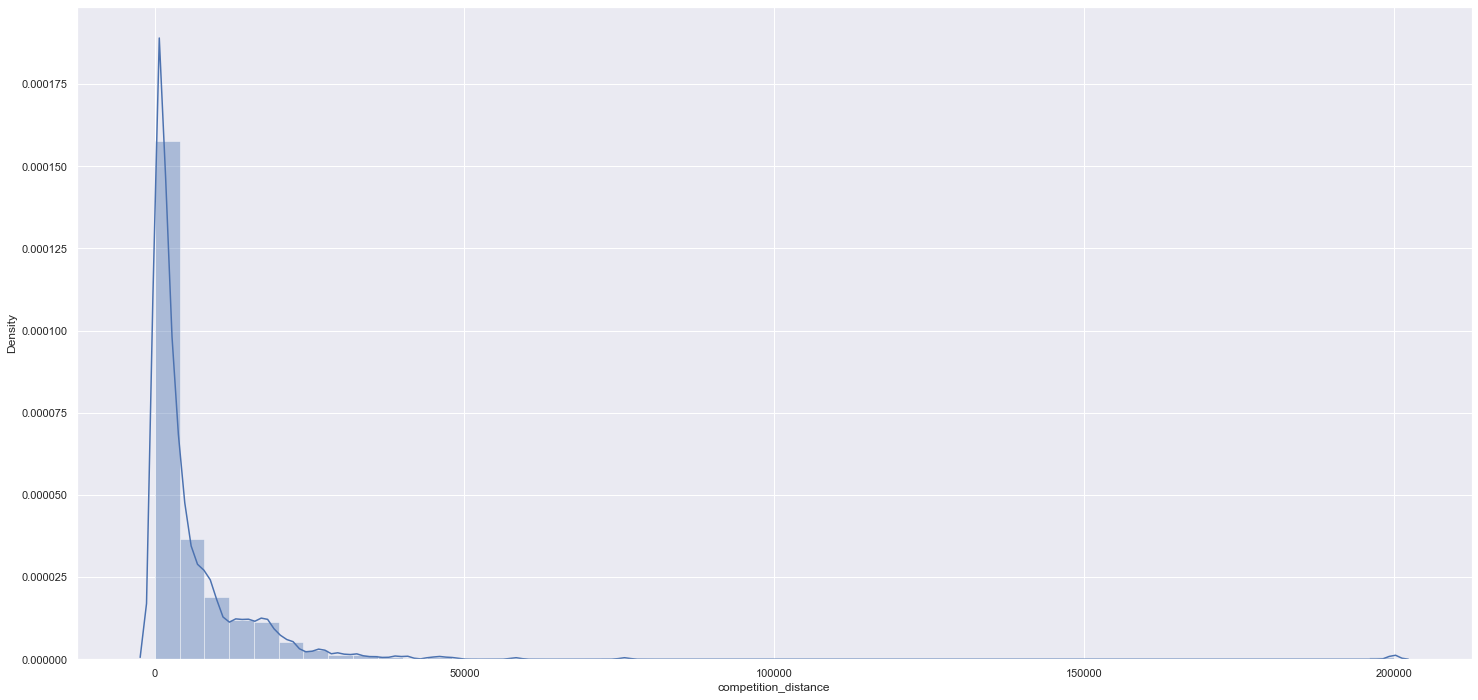

In [14]:
sns.distplot(df1['competition_distance']);

### 1.7.2. Categorical Attrributes

In [15]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

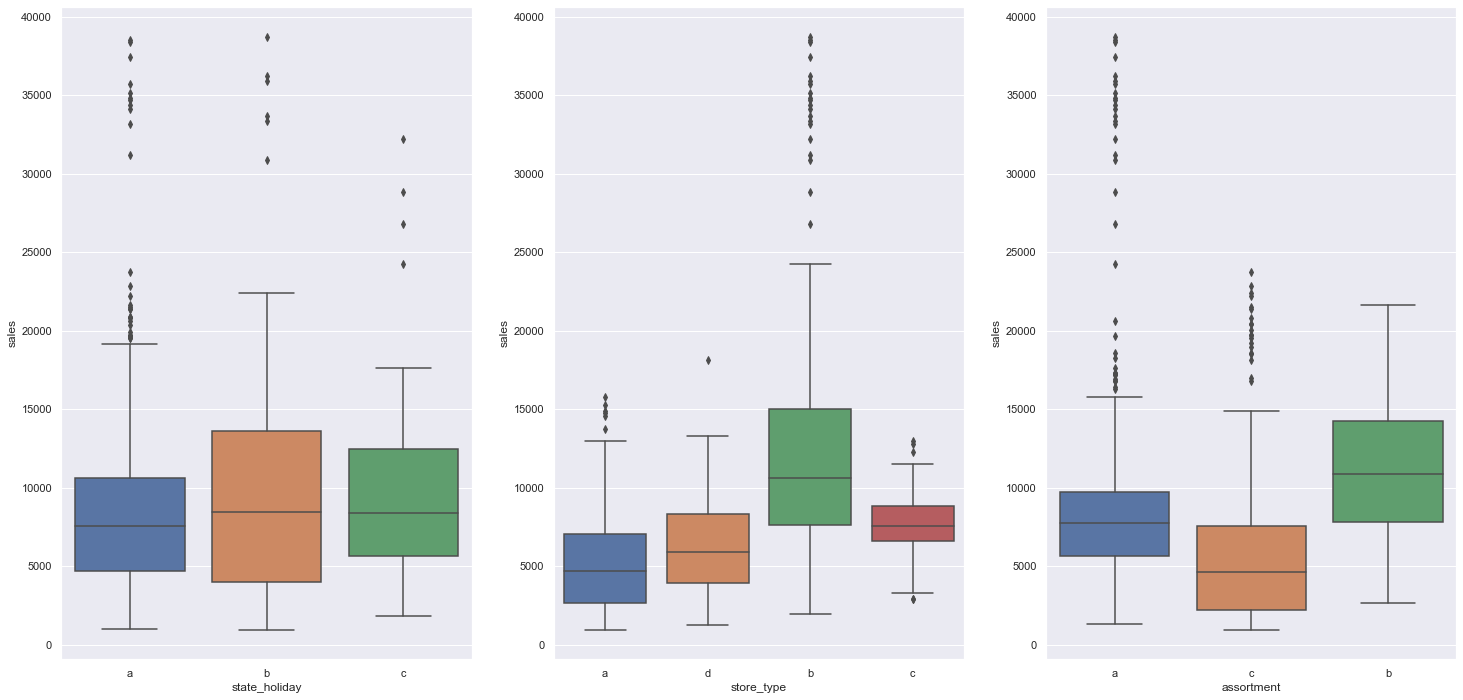

In [16]:
aux = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.subplot( 1, 3, 1 )
sns.boxplot( x='state_holiday', y='sales', data=aux );

plt.subplot( 1, 3, 2 )
sns.boxplot( x='store_type', y='sales', data=aux );

plt.subplot( 1, 3, 3 )
sns.boxplot( x='assortment', y='sales', data=aux );

# 2.0. FEATURE ENGENEERING

In [17]:
df2 = df1.copy()

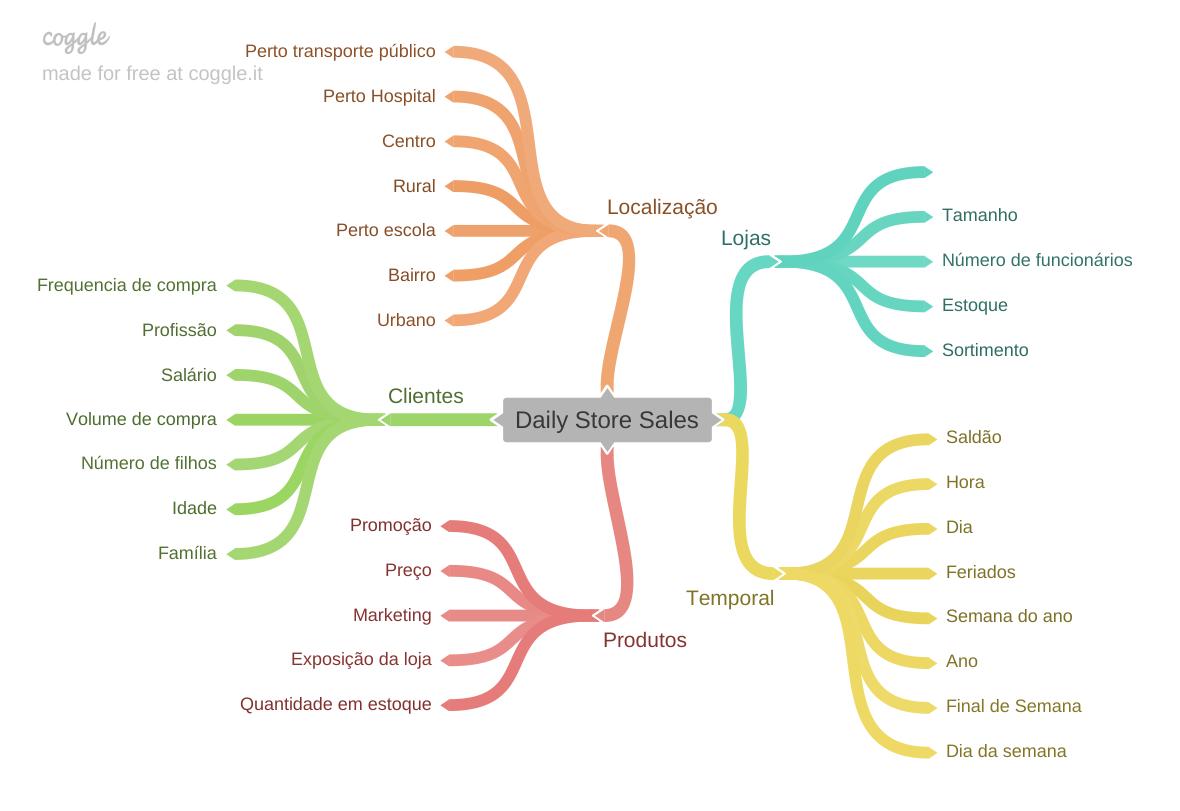

In [18]:
Image('img/Daily_Store_Sales.png')

## 2.1. Hypothesis creation

### 2.1.1. Store Hypothesis

**1.** Lojas com maior número de funcionários deveriam vender mais.

**2.** Lojas com maior capacidade de estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com maior sortimento deveriam vender mais.

**5.** Lojas com competidores mais perto deveriam vender mais.

**6.** Lojas com competidores há mais tempo deveriam vender mais.

### 2.1.2. Product Hypothesis

**1.** Lojas que investem mais em Marketing deveriam vender mais.

**2.** Lojas com maior exposição dos produtos deveriam vender mais.

**3.** Lojas com menor preço dos produtos deveriam vender mais.

**4.** Lojas com promoções mais agressivas deveriam vender mais.

**5.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**6.** Lojas com mais dias de promoções deveriam vender mais.

**7.** Lojas com mais promoções consecutivas deveriam vender mais.

### 2.1.3. Time Hypothesis

**1.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**2.** Lojas deveriam vender mais ao longo dos anos.

**3.** Lojas deveriam vender mais no segundo semestre do ano.

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**5.** Lojas deveriam vender menos aos finais de semana.

**6.** Lojas deveriam vender menos durante os feriados escolares.

## 2.2. Final hypothsis list

**1.** Lojas com maior sortimento deveriam vender mais.

**2.** Lojas com competidores mais perto deveriam vender mais.

**3.** Lojas com competidores há mais tempo deveriam vender mais.

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promoções deveriam vender mais.

**6.** Lojas com mais promoções consecutivas deveriam vender mais.

**7.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**8.** Lojas deveriam vender mais ao longo dos anos.

**9.** Lojas deveriam vender mais no segundo semestre do ano.

**10.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**11.** Lojas deveriam vender menos aos finais de semana.

**12.** Lojas deveriam vender menos durante os feriados escolares.

## 2.3. Featuring engineering

In [19]:
# Year
df2['year'] = df2['date'].dt.year

# Month
df2['month'] = df2['date'].dt.month

# Day
df2['day'] = df2['date'].dt.day

# Week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week

# Year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

# Competition since
df2['competition_since'] = df2.apply(
    lambda x: datetime.datetime(
        year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)

df2['competition_time_month'] = (
    (df2['date'] - df2['competition_since']) / 30).apply(
        lambda x: x.days).astype(int)

# Competition promo
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))
df2['promo_time_week'] = ((df2['date'] - df2['promo_since']) / 7).apply(lambda x: x.days).astype(int)

# Assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

# State Holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

# 3.0. DATA FILTERING

In [20]:
df3 = df2.copy()  # Backup

## 3.1. Lines filtering

In [21]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2. Columns filtering

In [22]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3.drop(cols_drop, axis=1)
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval', 'month_map', 'is_promo', 'year',
       'month', 'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

# 4.0. EXPLORATORY DATA ANALISYS (EDA)

In [23]:
df4 = df3.copy()

## 4.1. Univariate Analysis

### 4.1.1. Response Variable

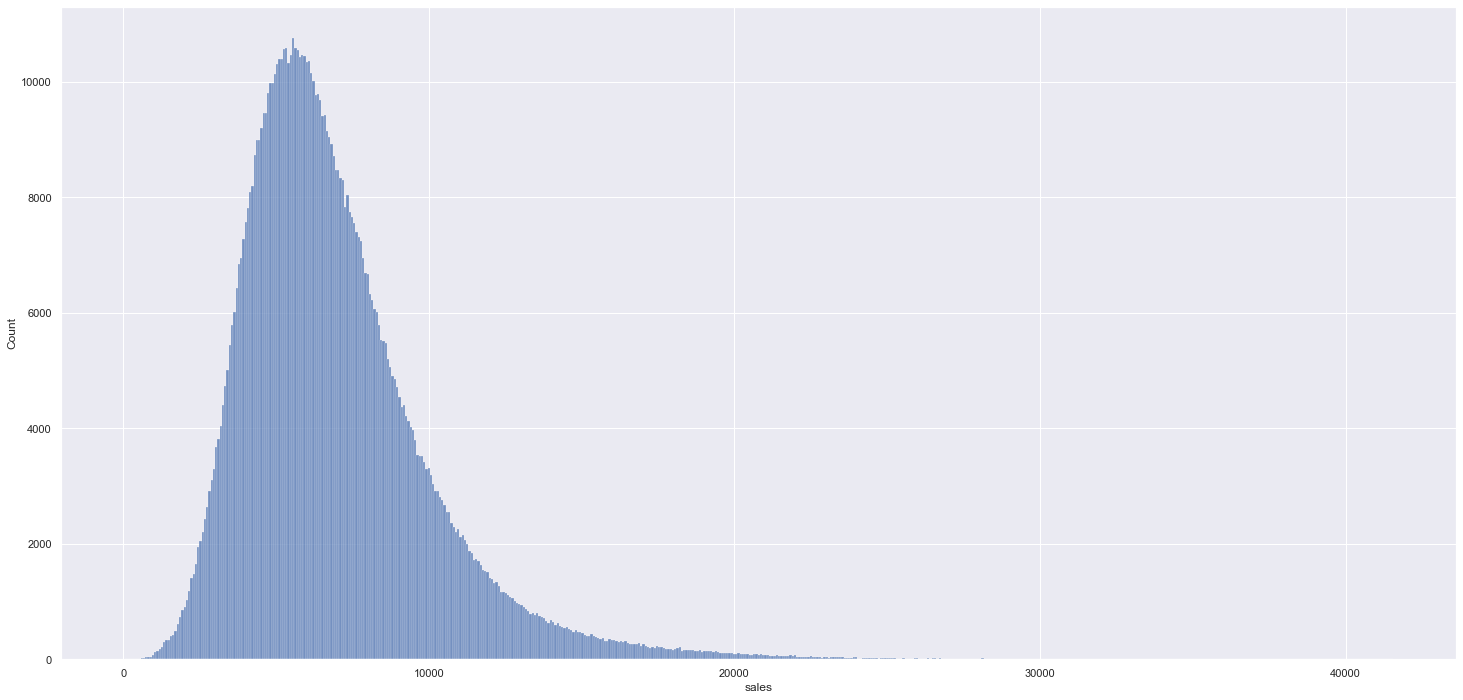

In [24]:
sns.histplot(df4.sales);

### 4.1.2. Numerical Variables

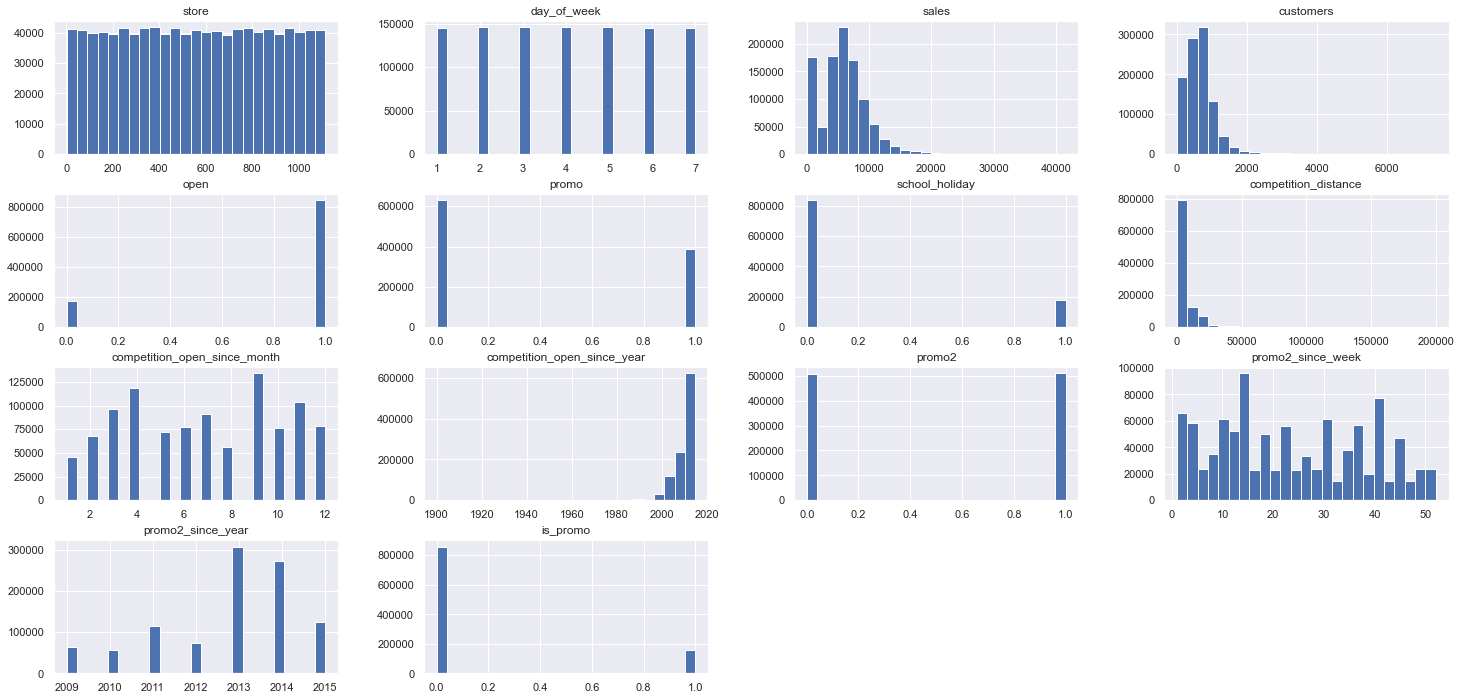

In [25]:
num_attributes.hist(bins=25);

### 4.1.3. Categorical Variables

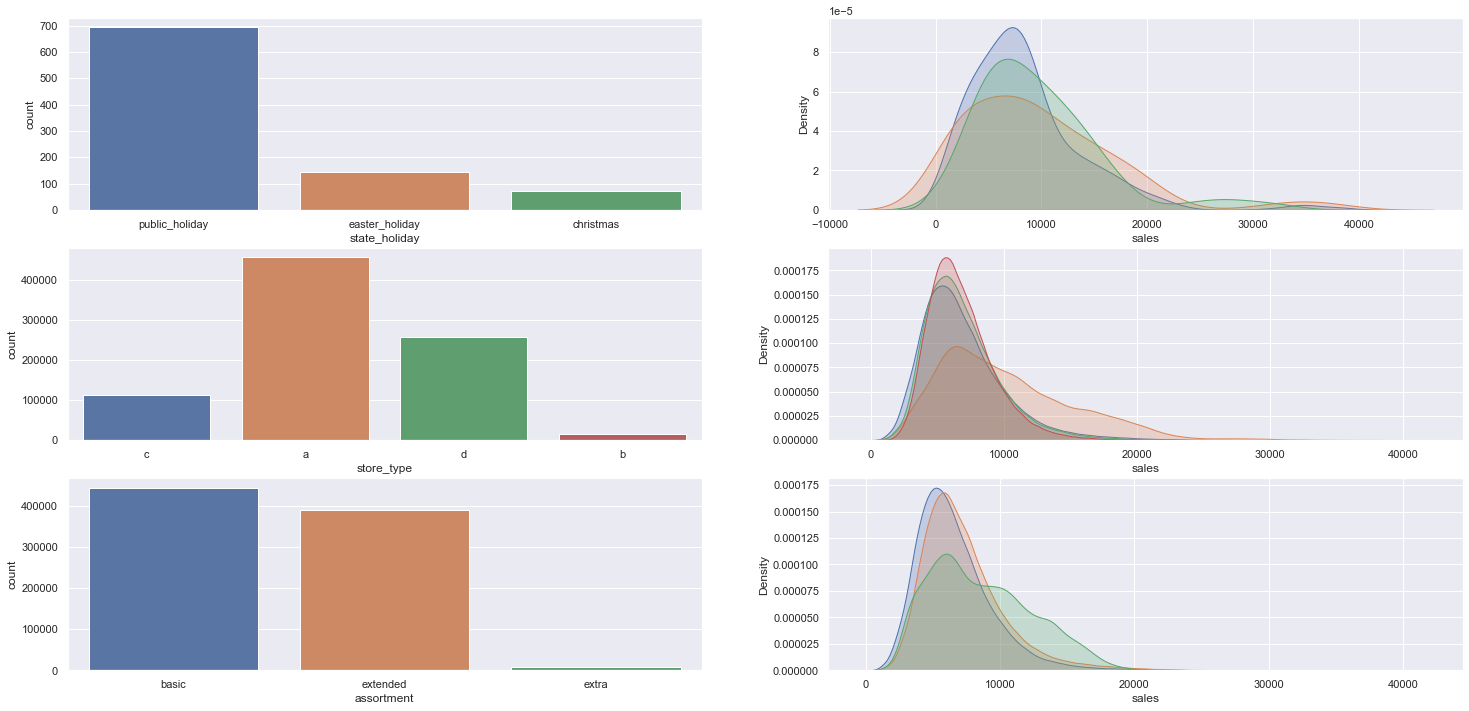

In [26]:
plt.subplot(3, 2, 1)
temp = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(temp['state_holiday'])

# State holiday
plt.subplot(3, 2, 2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True);
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True);
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas_holiday', shade=True);

# Store type
plt.subplot(3, 2, 3)
sns.countplot(df4['store_type']);

plt.subplot(3, 2, 4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label='a', shade=True);
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label='b', shade=True);
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label='c', shade=True);
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label='d', shade=True);

# Assortment
plt.subplot(3, 2, 5)
sns.countplot(df4['assortment']);

plt.subplot(3, 2, 6)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label='basic', shade=True);
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label='extended', shade=True);
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label='extra', shade=True);

## 4.2. Bivariate Analysis

### **H1.** Lojas com maior sortimento deveriam vender mais.
**FALSA** Lojas com MAIOR SORTIMENTO vendem MENOS

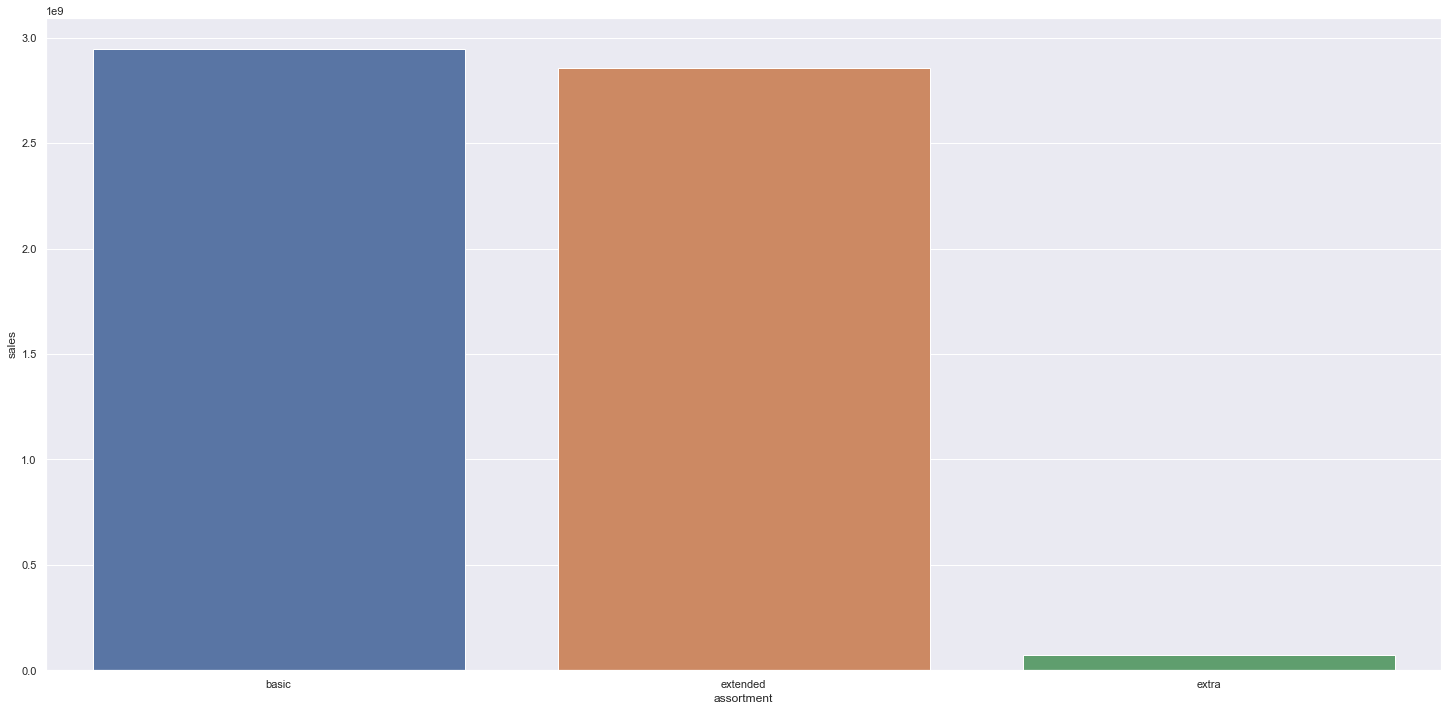

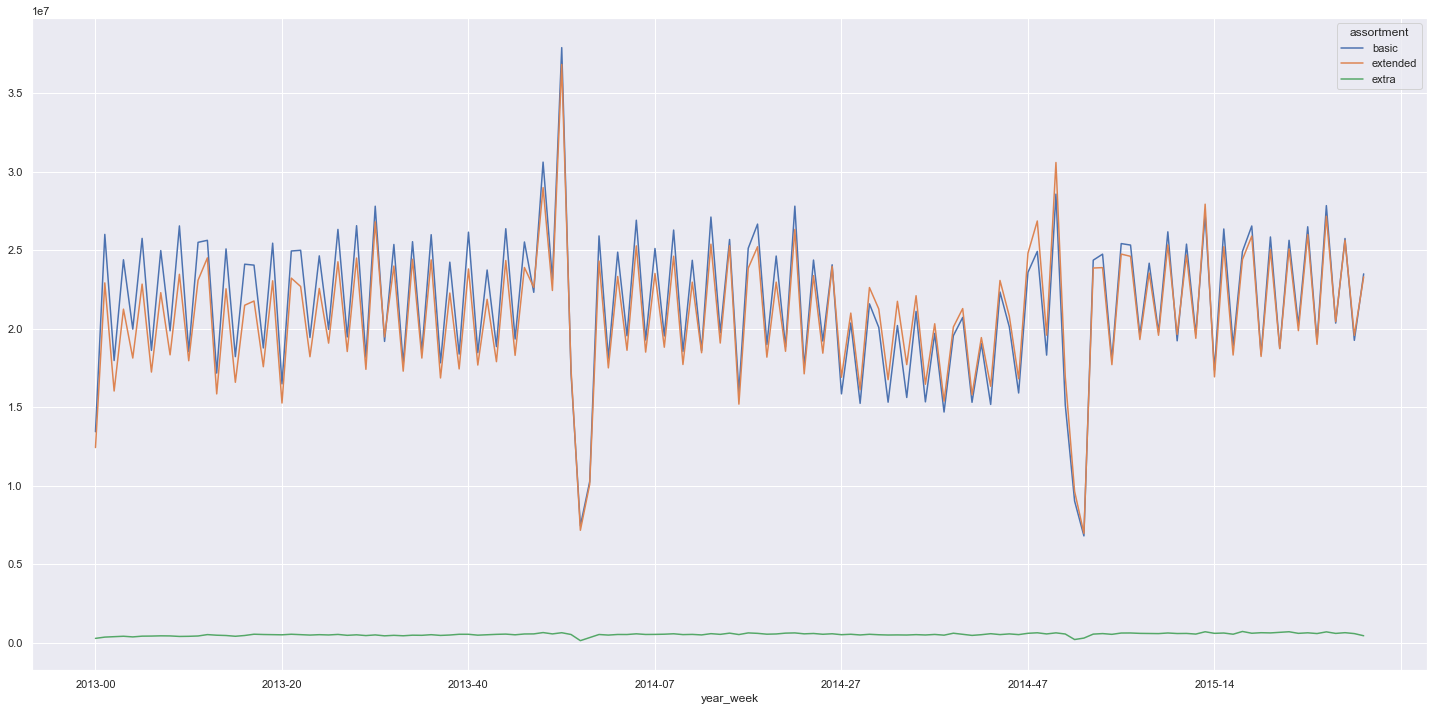

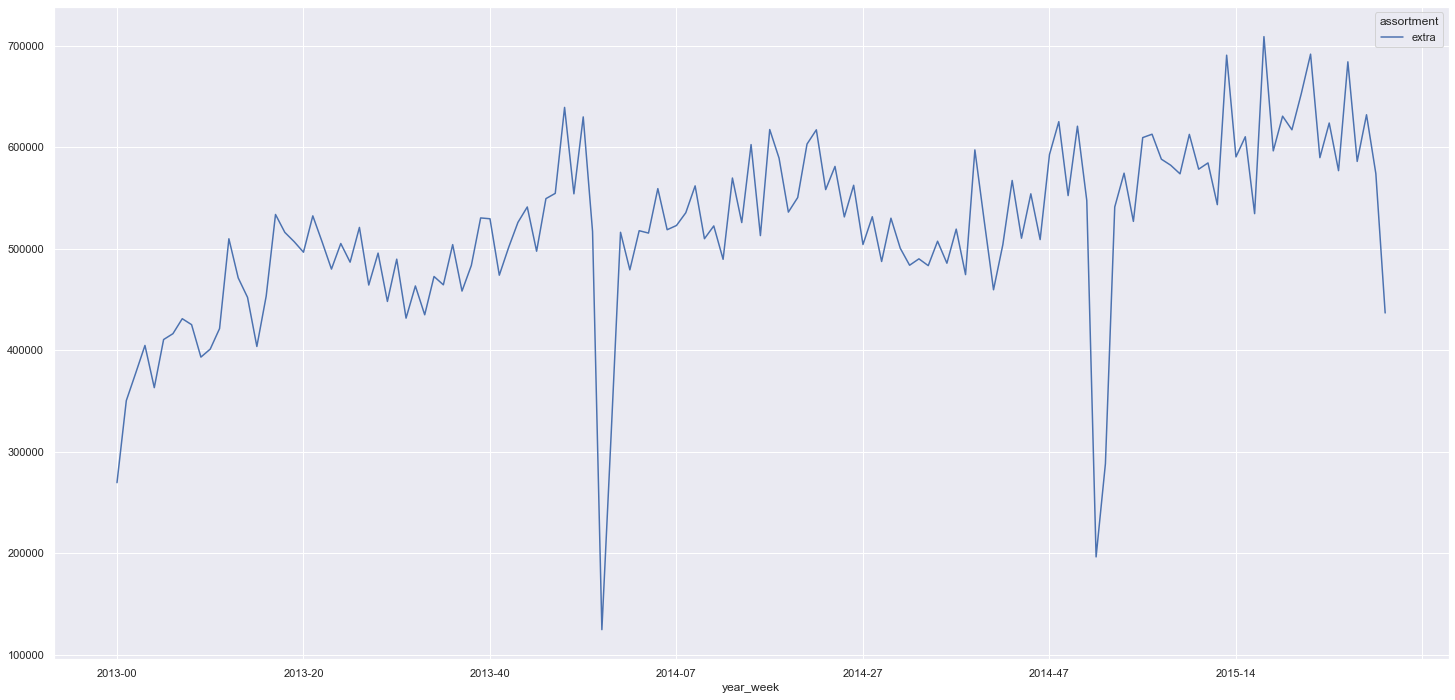

In [27]:
temp = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot(x='assortment', y='sales', data=temp);

temp = df4[['year_week', 'assortment', 'sales']].groupby(['year_week', 'assortment']).sum().reset_index()
temp.pivot(index='year_week', columns='assortment', values='sales').plot();

temp = temp[temp['assortment'] == 'extra']
temp.pivot(index='year_week', columns='assortment', values='sales').plot();

### **H2.** Lojas com competidores mais perto deveriam vender mais.
**VERDADEIRA**

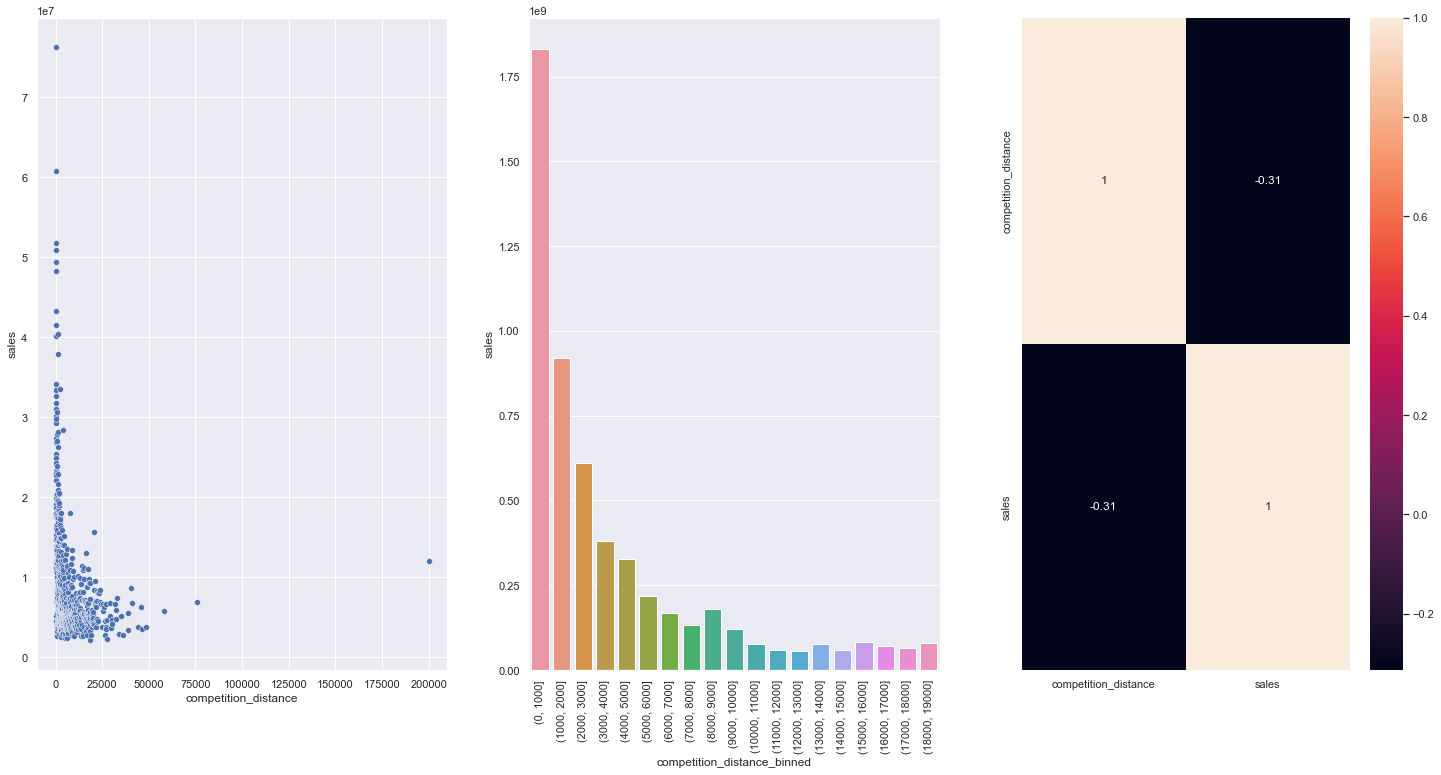

In [28]:
temp = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

plt.subplot(1, 3, 1)
sns.scatterplot(x='competition_distance', y='sales', data = temp)

plt.subplot(1, 3, 3)
sns.heatmap(temp[temp['competition_distance'] < 200000].corr(method='pearson'), annot=True);

plt.subplot(1, 3, 2)
bins = list(np.arange(0, 20000, 1000))
temp['competition_distance_binned'] = pd.cut(temp['competition_distance'], bins=bins)
temp = temp[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot(x='competition_distance_binned', y='sales', data = temp);
plt.xticks(rotation=90);

### **H3.** Lojas com competidores há mais tempo deveriam vender mais.
**FALSA** Lojas com competidores há MAIS TEMPO vendem MENOS

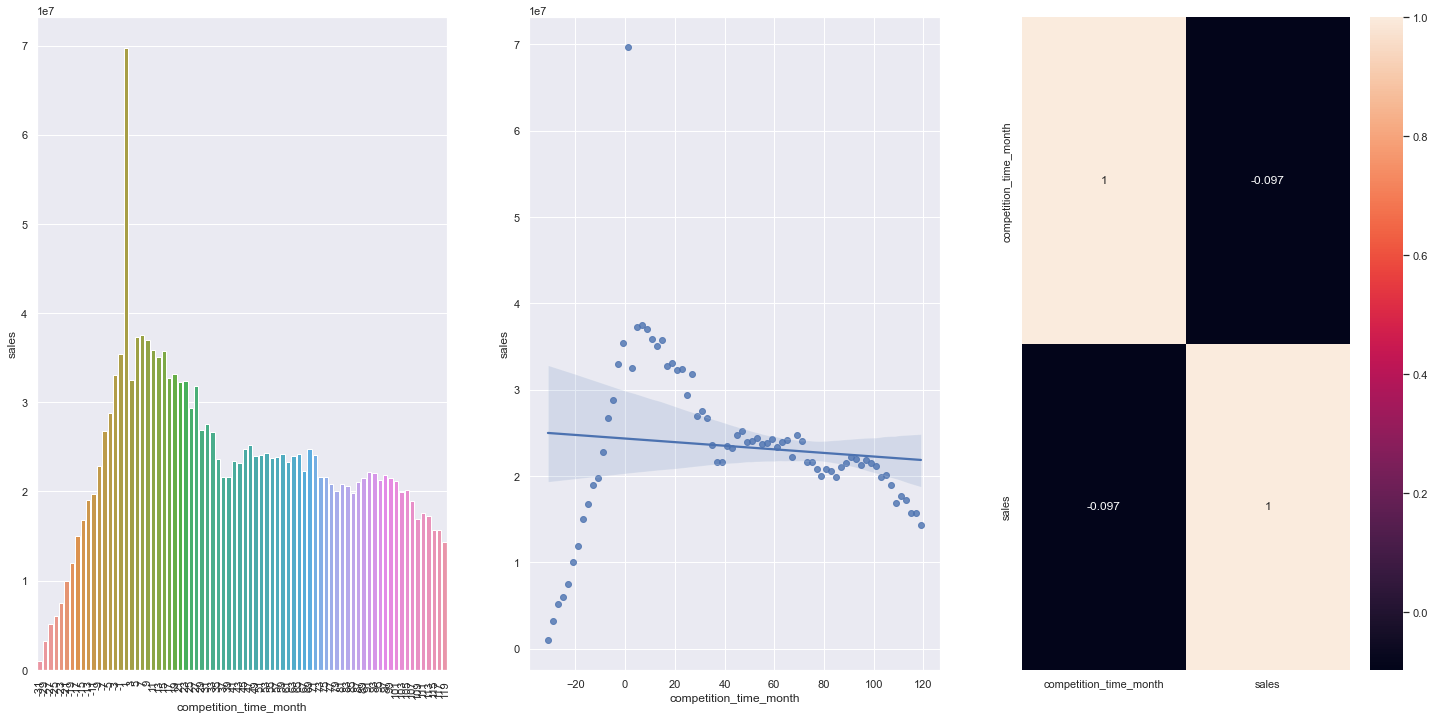

In [29]:
plt.subplot(1, 3, 1)
temp = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
temp = temp[(temp['competition_time_month'] < 120) & temp['competition_time_month'] != 0]
sns.barplot(x='competition_time_month', y='sales', data=temp);
plt.xticks(rotation=90);

plt.subplot(1, 3, 2)
sns.regplot(x='competition_time_month', y='sales', data=temp);

plt.subplot(1, 3, 3)
sns.heatmap(temp.corr(method='pearson'), annot=True);

### **H4.** Lojas com promoções ativas por mais tempo deveriam vender mais.
**FALSA** Lojas com promoções ativas por MAIS TEMPO vendem MENOS depois de um certo período de tempo

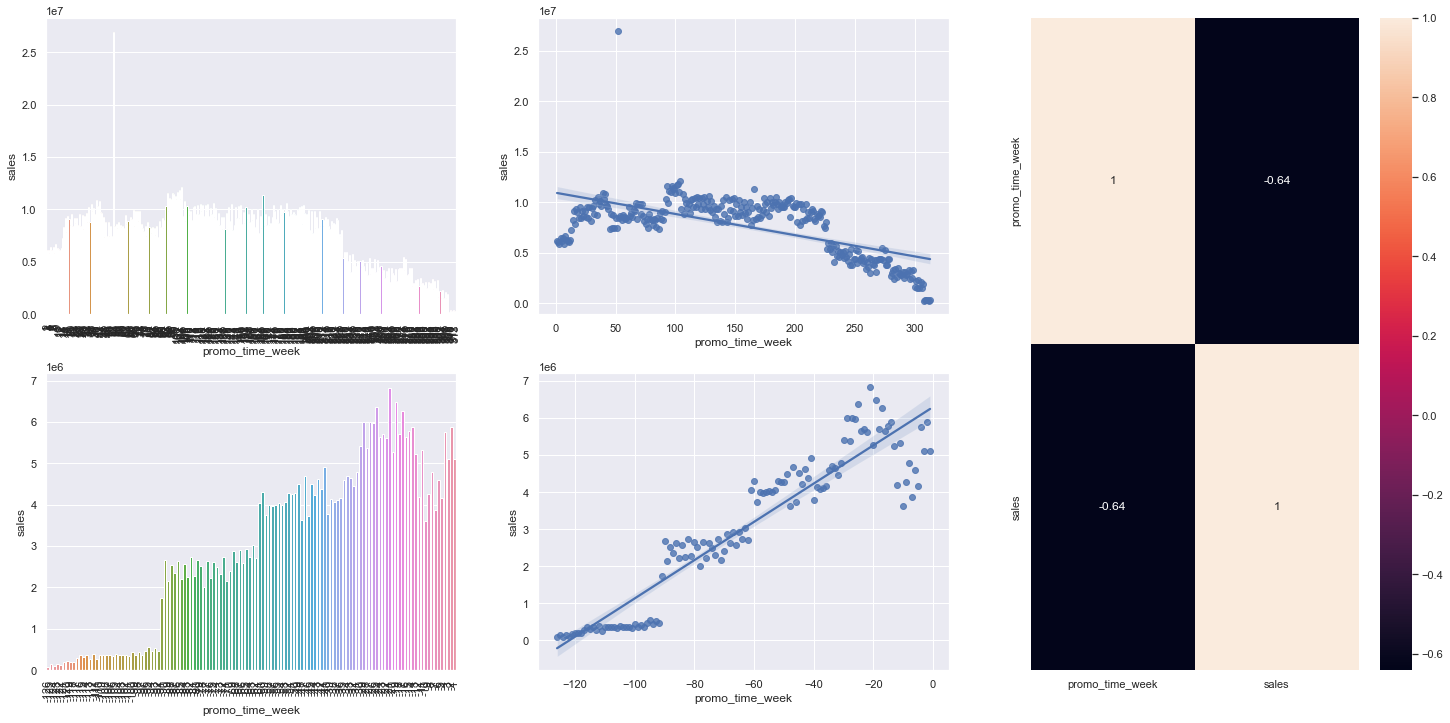

In [30]:
grid = GridSpec(2, 3)

plt.subplot(grid[0, 0])
temp = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()
temp = temp[temp['promo_time_week'] > 0]
sns.barplot(x='promo_time_week', y='sales', data=temp);
plt.xticks(rotation=90);

plt.subplot(grid[:, 2])
sns.heatmap(temp.corr(method='pearson'), annot=True)

plt.subplot(grid[0, 1])
sns.regplot(x='promo_time_week', y='sales', data=temp);

plt.subplot(grid[1, 0])
temp = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()
temp = temp[temp['promo_time_week'] < 0]
sns.barplot(x='promo_time_week', y='sales', data=temp);
plt.xticks(rotation=90);

plt.subplot(grid[1, 1])
sns.regplot(x='promo_time_week', y='sales', data=temp);

### <s>**H5.** Lojas com mais dias de promoções deveriam vender mais.</s>

### **H6.** Lojas com mais promoções consecutivas deveriam vender mais.
**FALSA** Lojas com promoções consecutivas vendem menos

In [31]:
df4[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


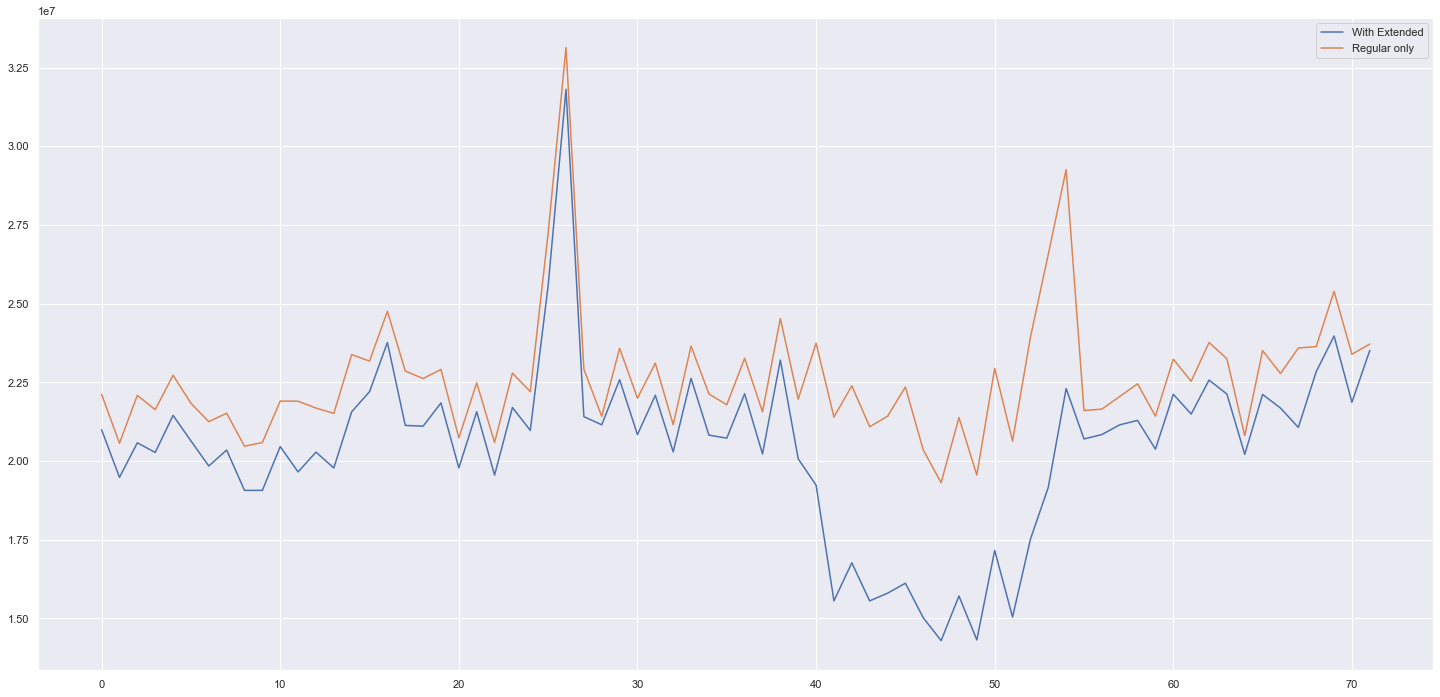

In [32]:
temp = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
ax = temp.plot()

temp = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
temp.plot(ax=ax);

ax.legend(labels=['With Extended', 'Regular only']);

### **H7.** Lojas abertas durante o feriado de Natal deveriam vender mais.
**FALSA** Lojas ABERTAS durante o feriado de Natal vendem MENOS

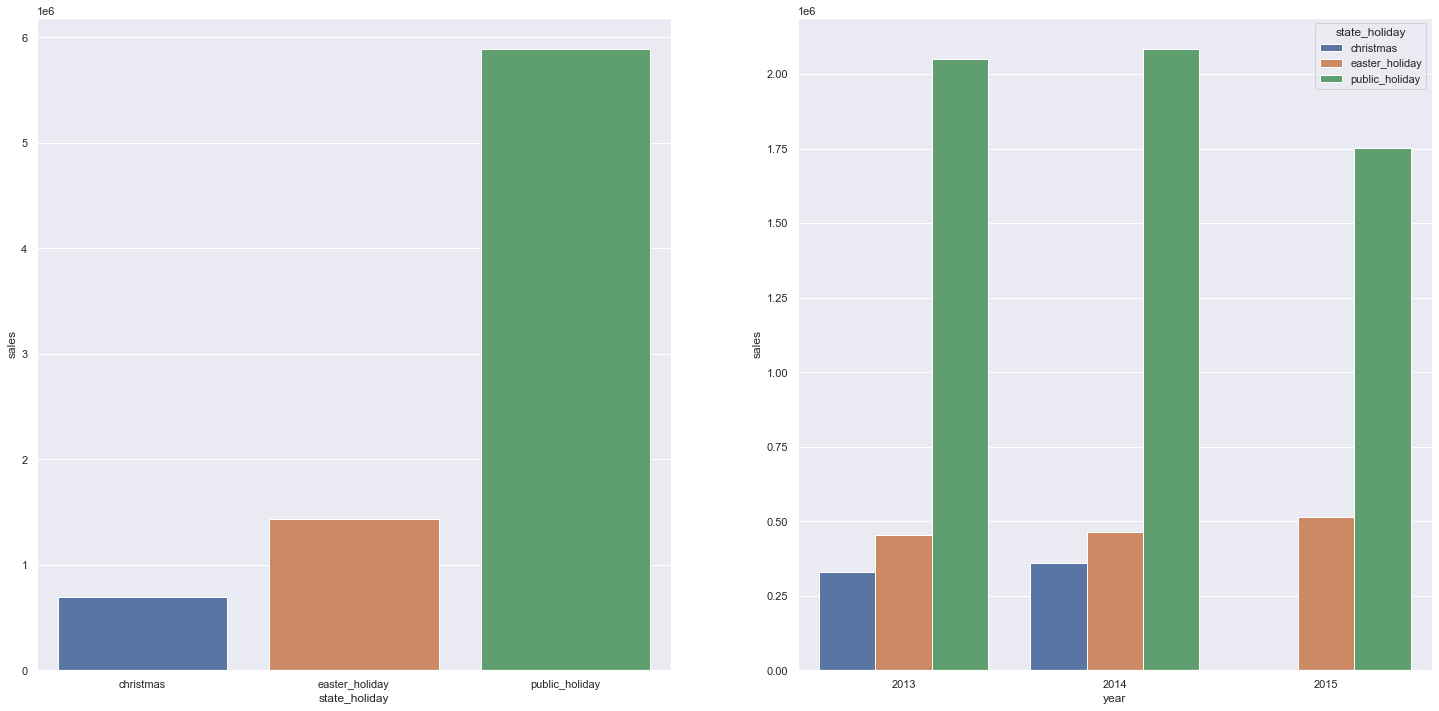

In [33]:
plt.subplot(121)
temp = df4[df4['state_holiday'] != 'regular_day']
temp = temp[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x='state_holiday', y='sales', data=temp);

plt.subplot(122)
temp = df4[df4['state_holiday'] != 'regular_day']
temp = temp[['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday']).sum().reset_index()
sns.barplot(x='year', y='sales', hue='state_holiday', data=temp);

### **H8.** Lojas deveriam vender mais ao longo dos anos.
**FALSA** Lojas vendem MENOS ao longo dos anos

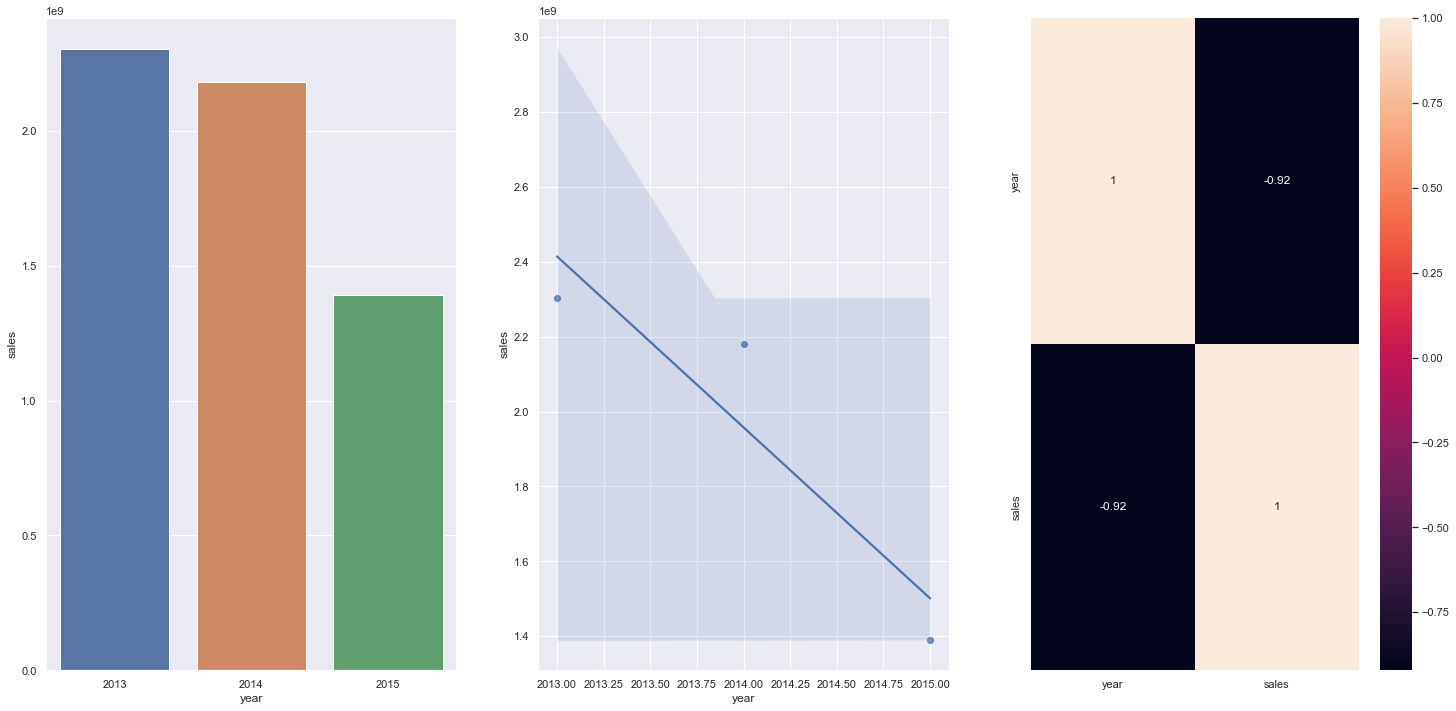

In [34]:
plt.subplot(1, 3, 1)
temp = df4[['year', 'sales']].groupby('year').sum().reset_index()
sns.barplot(x='year', y='sales', data=temp);

plt.subplot(1, 3, 2)
sns.regplot(x='year', y='sales', data=temp);

plt.subplot(1, 3, 3)
sns.heatmap(temp.corr(method='pearson'), annot=True);

### **H9.** Lojas deveriam vender mais no segundo semestre do ano.
**FALSA** Lojas vendem MENOS no segundo semestre do ano

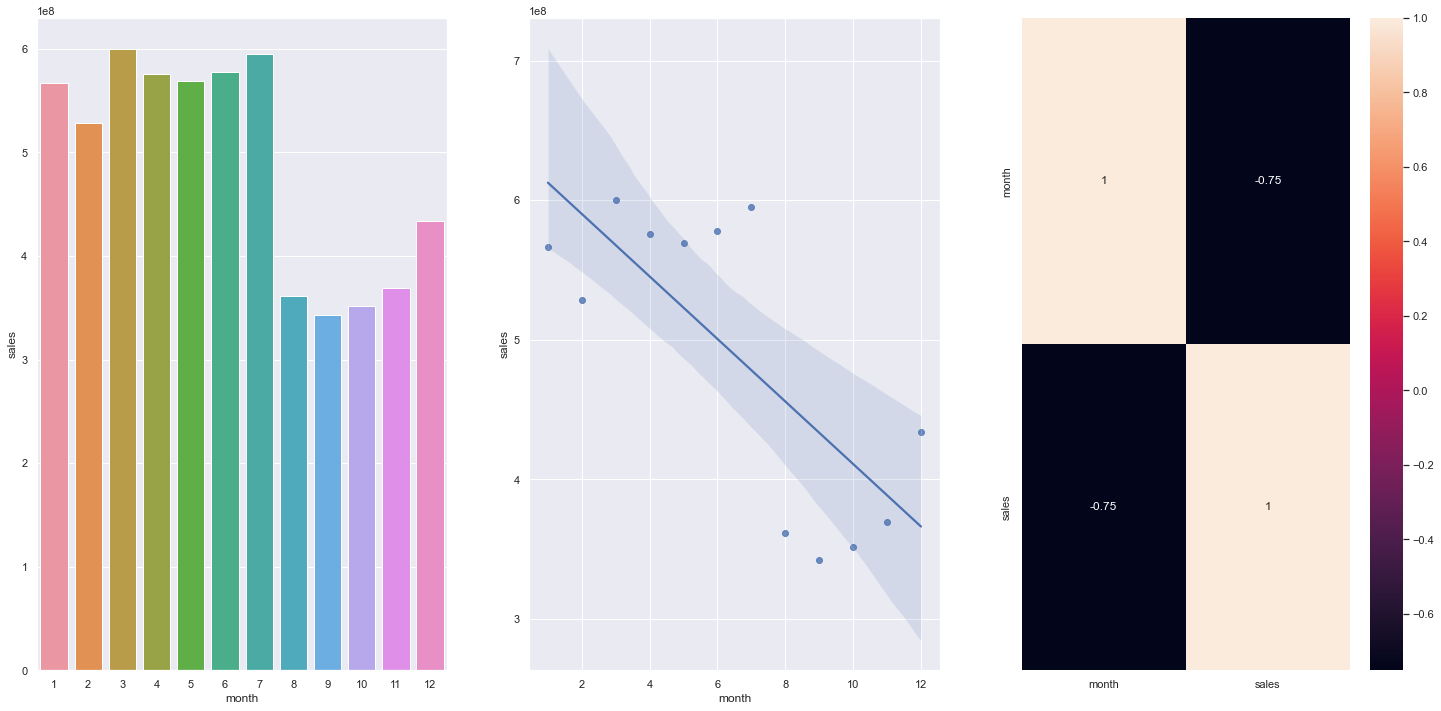

In [35]:
plt.subplot(1, 3, 1)
temp = df4[['month', 'sales']].groupby('month').sum().reset_index()
sns.barplot(x='month', y='sales', data=temp);

plt.subplot(1, 3, 2)
sns.regplot(x='month', y='sales', data=temp);

plt.subplot(1, 3, 3)
sns.heatmap(temp.corr(method='pearson'), annot=True);

### **H10.** Lojas deveriam vender mais depois do dia 10 de cada mês.
**VERDADEIRA** Lojas vendem MAIS depois do dia 10 de cada mês

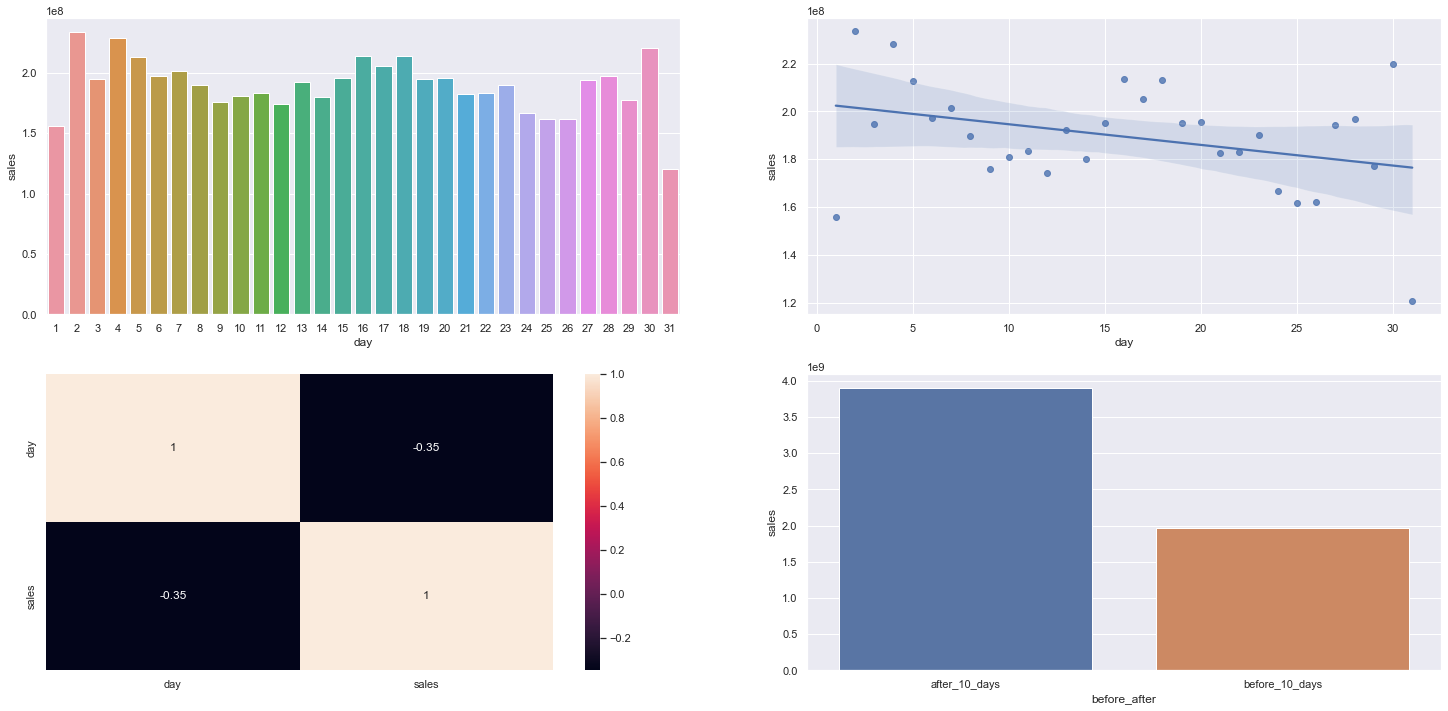

In [36]:
plt.subplot(2, 2, 1)
temp = df4[['day', 'sales']].groupby('day').sum().reset_index()
sns.barplot(x='day', y='sales', data=temp);

plt.subplot(2, 2, 2)
sns.regplot(x='day', y='sales', data=temp);

plt.subplot(2, 2, 3)
sns.heatmap(temp.corr(method='pearson'), annot=True);

temp['before_after'] = temp['day'].apply(lambda x: 'before_10_days' if x <= 10 else 'after_10_days')
temp = temp[['before_after', 'sales']].groupby('before_after').sum().reset_index()

plt.subplot(2, 2, 4)
sns.barplot(x='before_after', y='sales', data=temp);

### **H11.** Lojas deveriam vender menos aos finais de semana.
**VERDADEIRA** Lojas vendem MENOS aos finais de semana, principalmente no domingo.

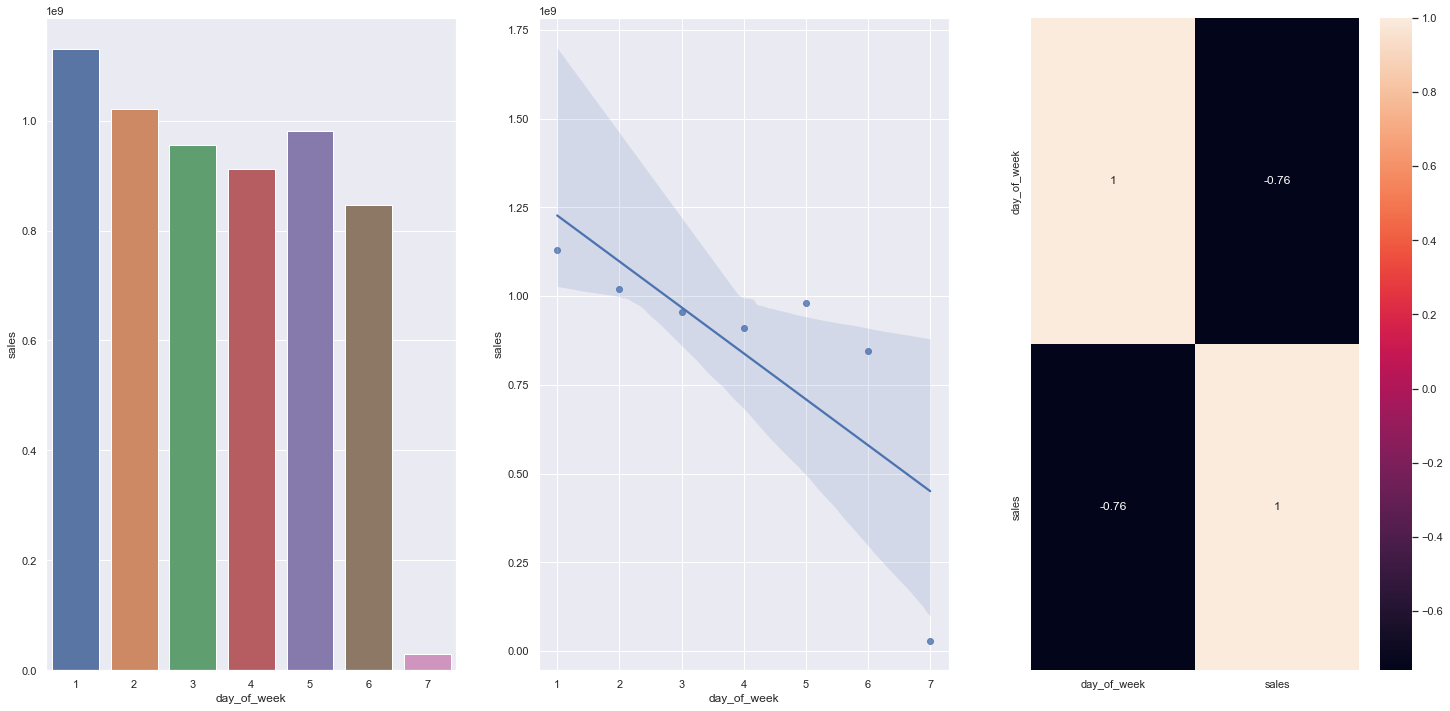

In [37]:
plt.subplot(1, 3, 1)
temp = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()
sns.barplot(x='day_of_week', y='sales', data=temp);

plt.subplot(1, 3, 2)
sns.regplot(x='day_of_week', y='sales', data=temp);

plt.subplot(1, 3, 3)
sns.heatmap(temp.corr(method='pearson'), annot=True);

### **H12.** Lojas deveriam vender menos durante os feriados escolares.
**VERDADEIRA** Lojas vendem menos em feriados escolares, exceto julho e agosto

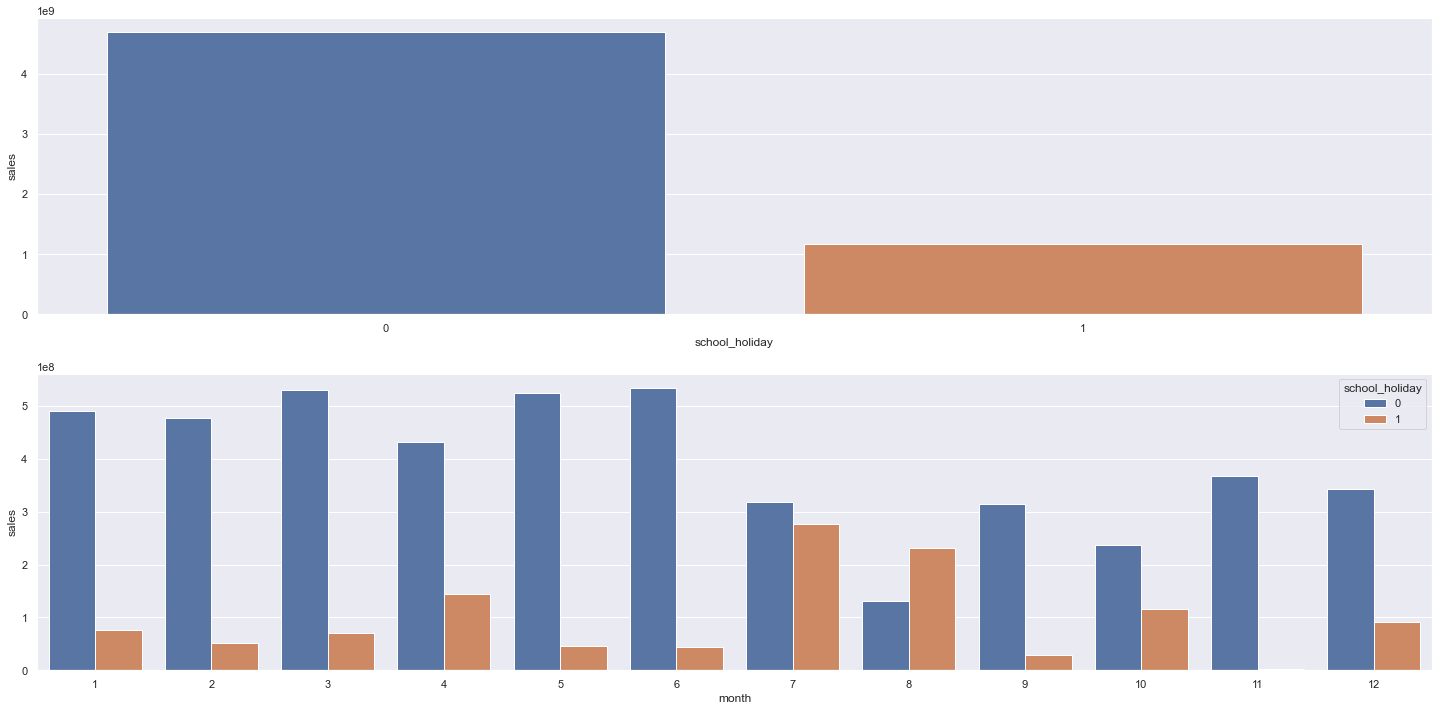

In [38]:
plt.subplot(2, 1, 1)
temp = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()
sns.barplot(x='school_holiday', y='sales', data=temp);

plt.subplot(2, 1, 2)
temp = df4[['month', 'school_holiday', 'sales']].groupby(['month', 'school_holiday']).sum().reset_index()
sns.barplot(x='month', y='sales',hue='school_holiday', data=temp);

### 4.2.1. Hypothesis summary

In [39]:
tab = [
    ['Hipotese', 'Conclusao', 'Relevancia'],
    ['H1', 'Falsa', 'Baixa'],
    ['H2', 'Falsa', 'Media'],
    ['H3', 'Falsa', 'Media'],
    ['H4', 'Falsa', 'Baixa'],
    ['H5', '-', '-'],
    ['H6', 'Falsa', 'Baixa'],
    ['H7', 'Falsa', 'Media'],   
    ['H8', 'Falsa', 'Alta'],
    ['H9', 'Falsa', 'Alta'],
    ['H10', 'Verdadeira', 'Alta'],
    ['H11', 'Verdadeira', 'Alta'],
    ['H12', 'Verdadeira', 'Baixa'],
]

print(tabulate(tab, headers='firstrow'))

Hipotese    Conclusao    Relevancia
----------  -----------  ------------
H1          Falsa        Baixa
H2          Falsa        Media
H3          Falsa        Media
H4          Falsa        Baixa
H5          -            -
H6          Falsa        Baixa
H7          Falsa        Media
H8          Falsa        Alta
H9          Falsa        Alta
H10         Verdadeira   Alta
H11         Verdadeira   Alta
H12         Verdadeira   Baixa


## 4.3. Multivariate Analysis

### 4.3.1 Numerical Attributes

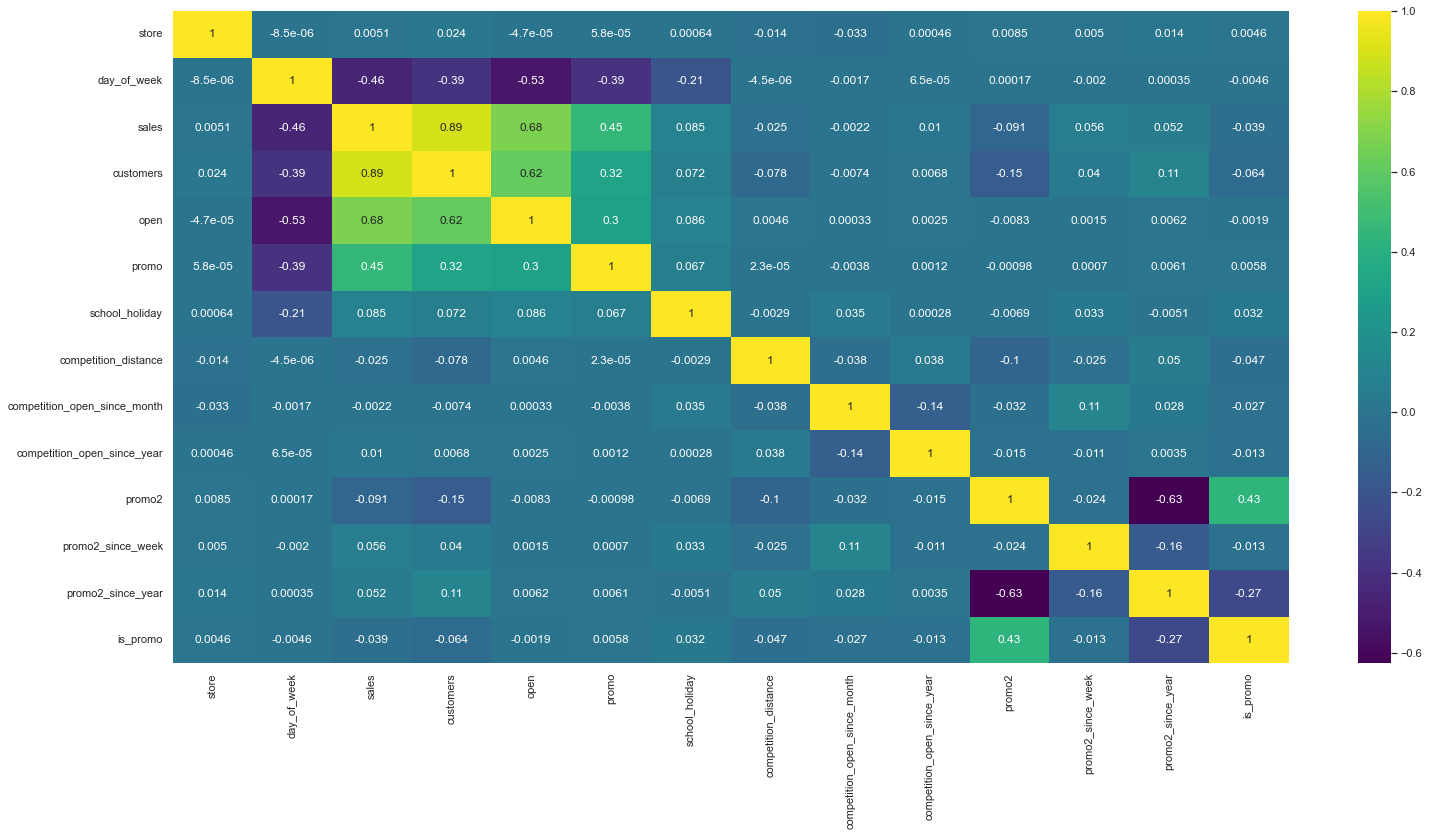

In [40]:
correlation = num_attributes.corr(method='pearson')
sns.heatmap(correlation, annot=True, cmap='viridis');

### 4.3.2 Categorical Attributes

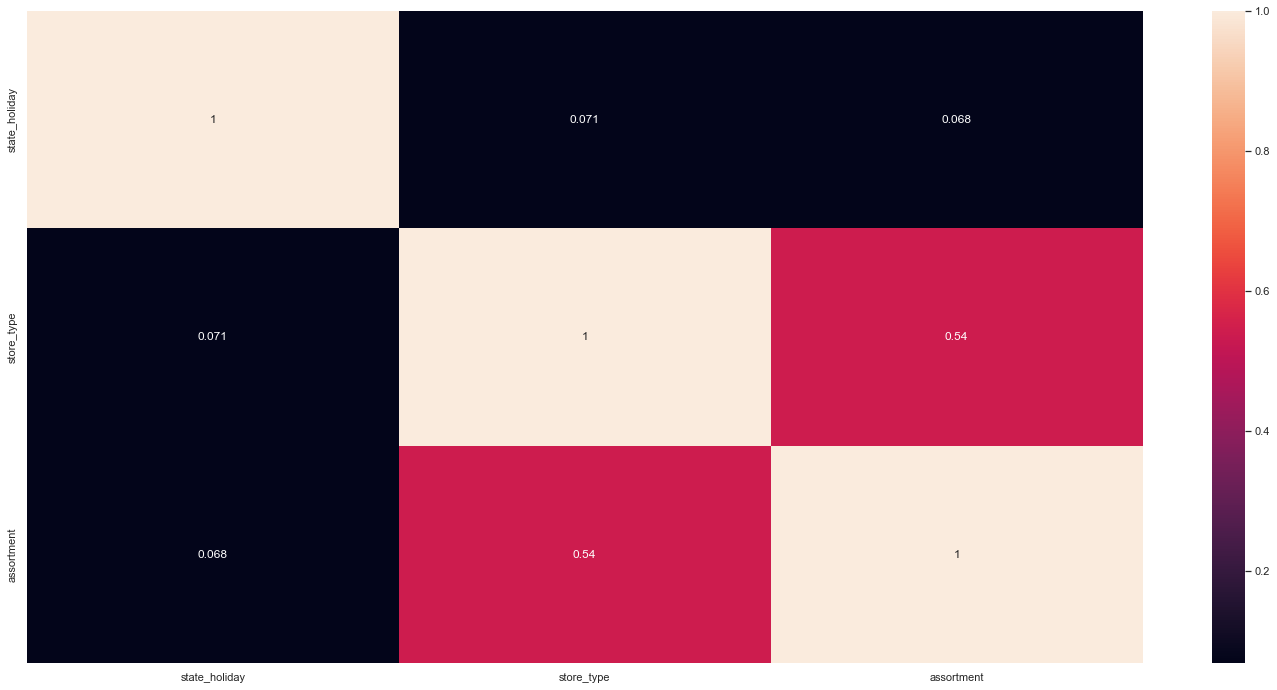

In [41]:
# Subset only categorical columns
a = df4.select_dtypes(include='object')

# Calculate Cramer V
a1 = cramer_v(a['state_holiday'], a['state_holiday'])
a2 = cramer_v(a['state_holiday'], a['store_type'])
a3 = cramer_v(a['state_holiday'], a['assortment'])

a4 = cramer_v(a['store_type'], a['state_holiday'])
a5 = cramer_v(a['store_type'], a['store_type'])
a6 = cramer_v(a['store_type'], a['assortment'])

a7 = cramer_v(a['assortment'], a['state_holiday'])
a8 = cramer_v(a['assortment'], a['store_type'])
a9 = cramer_v(a['assortment'], a['assortment'])

# Final dataset
d = pd.DataFrame(
    {
        'state_holiday': [a1, a2, a3],
        'store_type': [a4, a5, a6],
        'assortment': [a7, a8, a9],
    })

d = d.set_index(d.columns)

# Heatmap
sns.heatmap(d, annot=True);

# 5.0. DATA PREPARATION

In [42]:
df5 = df4.copy()

## 5.1. Normalization
Because it was not possible to identify any normal distribution in section 4.1.2., there will be no data normalization.

## 5.2. Rescaling

In [43]:
rs = RobustScaler()
mms = MinMaxScaler()

# competition_distance
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)
pickle.dump(rs, open('parameter/competition_distance_scaler.pkl', 'wb'))

# competition_time_month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)
pickle.dump( rs, open('parameter/competition_time_month_scaler.pkl', 'wb'))

# promo_time_week
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)
pickle.dump(mms, open('parameter/promo_time_week_scaler.pkl', 'wb'))

# year
df5['year'] = mms.fit_transform(df5[['year']].values)
pickle.dump(mms, open('parameter/year_scaler.pkl', 'wb'))

## 5.3. Transformation

### 5.3.1. Encoding

In [44]:
# State holiday - One hot encoding
df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

# Store_type - Label encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])
pickle.dump(le, open('parameter/store_type_scaler.pkl', 'wb'))

# Assortment - Ordinal encoding
assortment_dict = {'basic': 0, 'extra': 1, 'extended': 2}
df5['assortment'] = df5['assortment'].map(assortment_dict)

### 5.3.2. Response variable transformation

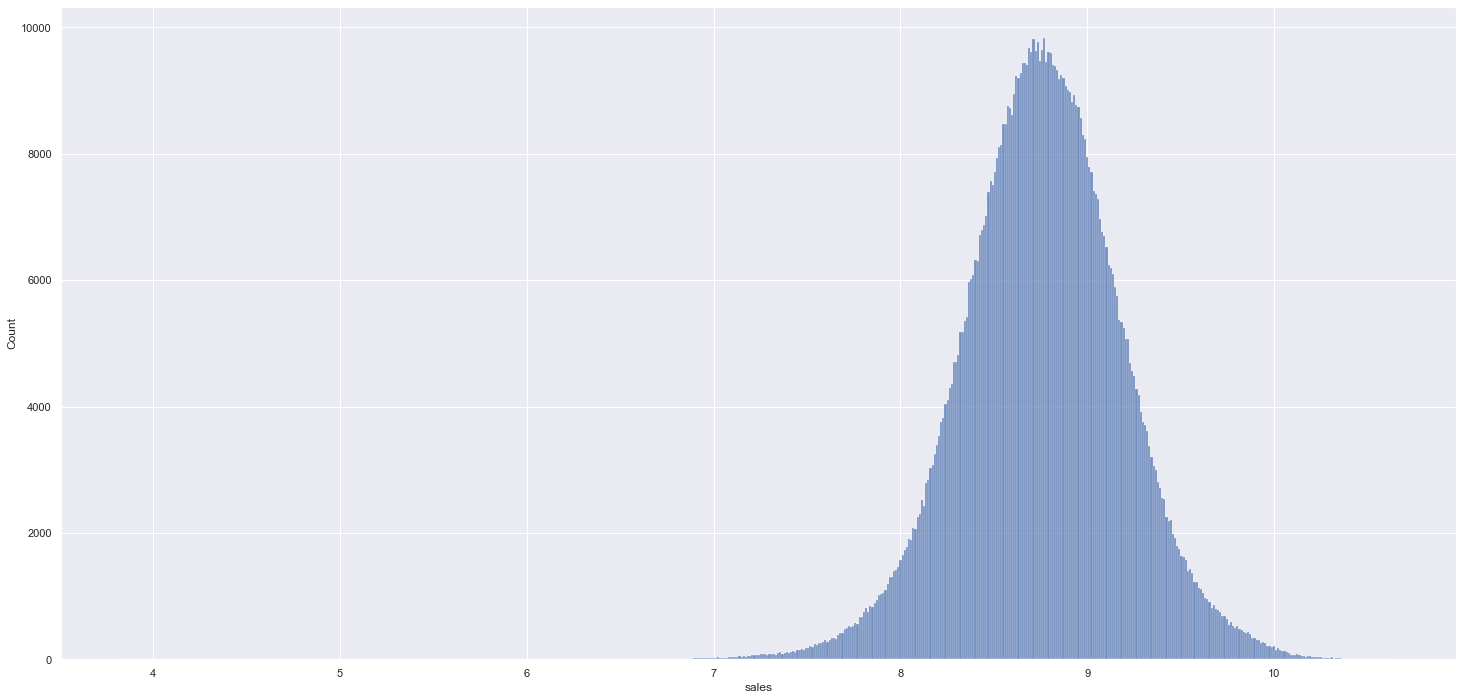

In [45]:
df5['sales'] = np.log1p(df5['sales'])
sns.histplot(df5.sales);

### 5.3.3. Nature transformation

In [46]:
# Day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x * (2. * np.pi / 7)))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x * (2. * np.pi / 7)))

# Month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x * (2. * np.pi / 12)))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x * (2. * np.pi / 12)))

# Day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x * (2. * np.pi / 30)))
df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x * (2. * np.pi / 30)))

# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x * (2. * np.pi / 52)))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x * (2. * np.pi / 52)))

# 6.0. FEATURE SELECTION

In [47]:
df6 = df5.copy()

## 6.1. Split dataframe into training and test datasets

In [48]:
df6.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'promo_interval', 'month_map',
       'is_promo', 'year', 'month', 'day', 'week_of_year', 'year_week',
       'competition_since', 'competition_time_month', 'promo_since',
       'promo_time_week', 'state_holiday_christmas',
       'state_holiday_easter_holiday', 'state_holiday_public_holiday',
       'state_holiday_regular_day', 'day_of_week_sin', 'day_of_week_cos',
       'month_sin', 'month_cos', 'day_sin', 'day_cos', 'week_of_year_sin',
       'week_of_year_cos'],
      dtype='object')

In [49]:
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week', 'promo_interval', 'month_map']
df6 = df6.drop(cols_drop, axis=1)

In [50]:
# Training dataset
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

# Test dataset
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

print('Training Min Date: {}'.format(X_train.date.min()))
print('Training Max Date: {}'.format(X_train.date.max()))

print('\nTest Min Date: {}'.format(X_test.date.min()))
print('Test Max Date: {}'.format(X_test.date.max()))

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


## 6.2. Boruta as Feature Selector

In [51]:
# # Training and test dataset for Boruta
# X_train_n = X_train.drop(['date', 'sales'], axis=1).values
# y_train_n = y_train.values.ravel()

# # Define RandomForestRegressor
# rf = RandomForestRegressor(n_jobs=-4)

# # Define Boruta
# boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42).fit(X_train_n, y_train_n)

### 6.2.1. Best Features from Boruta

In [52]:
# cols_selected = boruta.support_.tolist()

# # Best features
# X_train_fs = X_train.drop(['date', 'sales'], axis=1)
# cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()

# cols_not_selected_boruta = np.setdiff1d(X_train_fs.columns, cols_selected_boruta)

## 6.3. Manual Feature Selection

In [53]:
cols_selected_boruta = [
    'store',
    'promo',
    'store_type',
    'assortment',
    'competition_distance',
    'competition_open_since_month',
    'competition_open_since_year',
    'promo2',
    'promo2_since_week',
    'promo2_since_year',
    'competition_time_month',
    'promo_time_week',
    'day_of_week_sin',
    'day_of_week_cos',
    'month_sin',
    'month_cos',
    'day_sin',
    'day_cos',
    'week_of_year_sin',
    'week_of_year_cos']

# columns to add
feat_to_add = ['date', 'sales']

cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend( feat_to_add )

# 7.0. MACHINE LEARNING MODELLING

In [54]:
x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]

# Time Series Data Preparation
x_training = X_train[cols_selected_boruta_full]
x_training.loc[:, ['date']] = pd.to_datetime(x_training['date'])

## 7.1. Average Model

In [55]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

# Prediction
aux2 = aux1[['store', 'sales']].groupby('store').mean().reset_index().rename(columns={'sales': 'predictions'})
aux1 = pd.merge(aux1, aux2, how='left', on='store')

yhat_baseline = aux1['predictions']

# Performance
baseline_result = ml_error('Average Model', np.expm1(y_test), np.expm1(yhat_baseline))
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.455051,1835.135542


## 7.2. Linear Regression Model

In [56]:
# Model
lr = LinearRegression().fit(x_train, y_train)

# Prediction
yhat_lr = lr.predict(x_test)

# Performance
lr_result = ml_error('Linear Regression', np.expm1(y_test), np.expm1(yhat_lr))
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1867.089774,0.292694,2671.049215


### 7.2.1. Linear Regression Model - Cross Validation

In [57]:
lr_result_cv = cross_validation(x_training, 5, 'Linear Regression', lr)
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,1867.09 +/- 0.0,0.29 +/- 0.0,2671.05 +/- 0.0


## 7.3. Linear Regression Regularized Model - Lasso

In [58]:
# Model
lrr = Lasso(alpha=0.01).fit(x_train, y_train)  # As smaller alpha the better is the result 

# Prediction
yhat_lrr = lrr.predict(x_test)

# Performance
lrr_result = ml_error('Linear Regression - Lasso', np.expm1(y_test), np.expm1(yhat_lrr))
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1891.704881,0.289106,2744.451737


### 7.3.1. Linear Regression Regularized Model - Cross Validation

In [59]:
lrr_result_cv = cross_validation(x_training, 5, 'Lasso', lrr)
lrr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,1867.09 +/- 0.0,0.29 +/- 0.0,2671.05 +/- 0.0


## 7.4. Random Forest Regressor

In [60]:
# Model
rf = RandomForestRegressor(n_estimators=100, n_jobs=-2, random_state=42).fit(x_train, y_train)

# Prediction
yhat_rf = rf.predict(x_test)

# Performance
rf_result = ml_error('Random Forest Regressor', np.expm1(y_test), np.expm1(yhat_lrr))
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,1891.704881,0.289106,2744.451737


### 7.4.1. Random Forest Regressor - Cross Validation

In [61]:
rf_result_cv = cross_validation(x_training, 5, 'Random Forest', rf)
rf_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest,1867.09 +/- 0.0,0.29 +/- 0.0,2671.05 +/- 0.0


## 7.5. XGBoost Regressor

In [62]:
# Model
model_xgb = xgb.XGBRegressor(objective='reg:squarederror',
                             n_estimators=100, 
                             eta=0.01, 
                             max_depth=10, 
                             subsample=0.7,
                             colsample_bytree=0.9 ).fit(x_train, y_train)

# Prediction
yhat_xgb = model_xgb.predict( x_test )

# Performance
xgb_result = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb ) )
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,6683.423528,0.949439,7330.693347


### 7.5.1. XGBoost Regressor - Cross Validation

In [63]:
xgb_result_cv = cross_validation(x_training, 5, 'XGBoost Regressor', model_xgb)
xgb_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,1867.09 +/- 0.0,0.29 +/- 0.0,2671.05 +/- 0.0


## 7.6. Model comparison

### 7.6.1. Single Performance

In [64]:
modelling_result = pd.concat([baseline_result, lr_result, lrr_result, rf_result, xgb_result])
modelling_result.sort_values('RMSE')

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.455051,1835.135542
0,Linear Regression,1867.089774,0.292694,2671.049215
0,Linear Regression - Lasso,1891.704881,0.289106,2744.451737
0,Random Forest Regressor,1891.704881,0.289106,2744.451737
0,XGBoost Regressor,6683.423528,0.949439,7330.693347


### 7.6.2. Real Performance - Cross Validation

In [65]:
modelling_result_cv = pd.concat([lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv])
modelling_result_cv.sort_values('RMSE CV')

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,1867.09 +/- 0.0,0.29 +/- 0.0,2671.05 +/- 0.0
0,Lasso,1867.09 +/- 0.0,0.29 +/- 0.0,2671.05 +/- 0.0
0,Random Forest,1867.09 +/- 0.0,0.29 +/- 0.0,2671.05 +/- 0.0
0,XGBoost Regressor,1867.09 +/- 0.0,0.29 +/- 0.0,2671.05 +/- 0.0


# 8.0. HYPERPARAMETER FINE TUNING


## 8.1. Random Search

In [66]:
# param = {
#     'n_estimators': [1500, 1700, 2500, 3000, 3500],
#     'eta': [0.01, 0.03],
#     'max_depth': [3, 5, 9],
#     'subsample': [0.1, 0.5, 0.7],
#     'colsample_bytee': [0.3, 0.7, 0.9],
#     'min_child_weight': [3, 8, 15]
# }

# MAX_EVAL = 5

In [67]:
# final_result = pd.DataFrame()

# for ii in range(MAX_EVAL):
#     # Choose values for parameters randomly
#     hp = {k: random.sample(v, 1)[0] for k, v in param.items()}
#     print(hp)
    
#     # Model
#     model_xgb = xgb.XGBRegressor(objective='reg:squarederror',
#                                  n_estimators=hp['n_estimators'], 
#                                  eta=hp['eta'], 
#                                  max_depth=hp['max_depth'], 
#                                  subsample=hp['subsample'],
#                                  colsample_bytee=hp['colsample_bytee'],
#                                  min_child_weight=hp['min_child_weight']
#                                 ).fit(x_train, y_train)

#     # Prediction
#     yhat_xgb = model_xgb.predict( x_test )

#     # Performance
#     result = cross_validation(
#         x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True)
#     final_result = pd.concat([final_result, result])

# final_result

## 8.2. Final Model

In [68]:
param_tuned = {
    'n_estimators': 3000,
    'eta': 0.03,
    'max_depth': 5,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'min_child_weight': 3 
}

In [69]:
# Model
model_xgb_tuned = xgb.XGBRegressor(objective='reg:squarederror',
                                   n_estimators=param_tuned['n_estimators'], 
                                   eta=param_tuned['eta'], 
                                   max_depth=param_tuned['max_depth'], 
                                   subsample=param_tuned['subsample'],
                                   colsample_bytree=param_tuned['colsample_bytree'],
                                   min_child_weight=param_tuned['min_child_weight']
                                  ).fit(x_train, y_train)

# Prediction
yhat_xgb_tuned = model_xgb_tuned.predict(x_test)

# Performance
xgb_result_tuned = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb_tuned))
xgb_result_tuned

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,767.867031,0.115342,1104.999627


In [70]:
mpe = mean_percentage_error(np.expm1(y_test), np.expm1(yhat_xgb_tuned))
mpe

-0.01674668729407388

# 9.0. ERROR TRANSLATION AND INTERPRETATION


In [71]:
df9 = X_test[cols_selected_boruta_full]

# Rescale
df9['sales'] = np.expm1(df9['sales'])
df9['predictions'] = np.expm1(yhat_xgb_tuned)

## 9.1. Business Performance

In [72]:
# sum of predictions
df91 = df9[['store', 'predictions']].groupby('store').sum().reset_index()

# MAE and MAPE
df9_aux1 = df9[['store', 'sales', 'predictions']].groupby(
    'store').apply(
    lambda x: mean_absolute_error(
        x['sales'], x['predictions'])).reset_index().rename(columns={0:'MAE'})
df9_aux2 = df9[['store', 'sales', 'predictions']].groupby(
    'store').apply(lambda x: mean_absolute_percentage_error(
    x['sales'], x['predictions'])).reset_index().rename(columns={0:'MAPE'})

# Merge
df9_aux3 = pd.merge(df9_aux1, df9_aux2, how='inner', on='store')
df92 = pd.merge(df91, df9_aux3, how='inner', on='store')

# Scenarios
df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']

# order columns
df92 = df92[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]

In [73]:
df92.sort_values( 'MAPE', ascending=False ).head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
291,292,107615.710938,104215.942100,111015.479775,3399.768837,0.602434
908,909,218553.062500,210585.819187,226520.305813,7967.243313,0.520197
169,170,210332.781250,208754.922376,211910.640124,1577.858874,0.388893
901,902,202310.546875,200840.207863,203780.885887,1470.339012,0.366374
875,876,196113.046875,192048.999575,200177.094175,4064.047300,0.328779


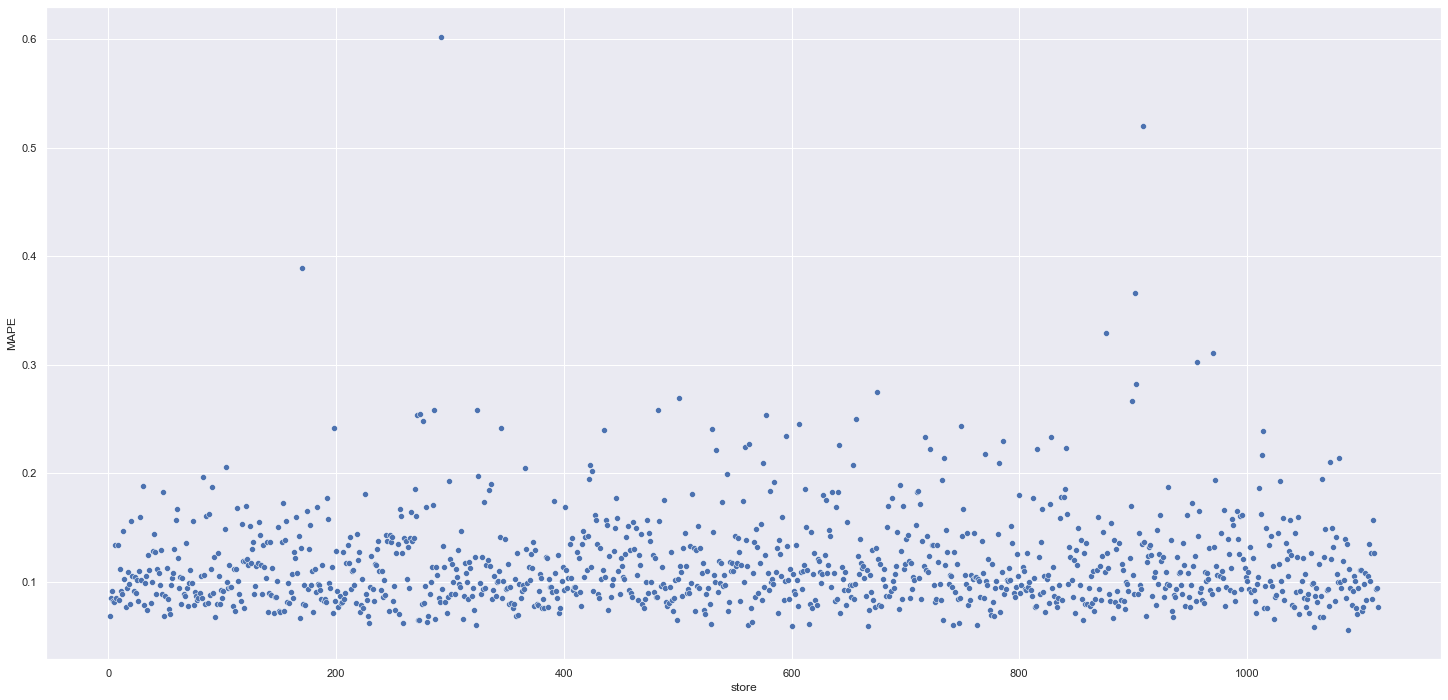

In [74]:
sns.scatterplot(x='store', y='MAPE', data=df92);

## 9.2. Total Performance

In [75]:
df93 = df92[['predictions', 'worst_scenario', 'best_scenario']].apply(
    lambda x: np.sum(x), axis=0).reset_index().rename(
    columns={'index': 'Scenario', 0:'Values'})
df93['Values'] = df93['Values'].map('R$ {:,.2f}'.format)
df93

,Scenario,Values
0,predictions,"R$ 285,982,336.00"
1,worst_scenario,"R$ 285,122,909.38"
2,best_scenario,"R$ 286,841,799.87"


## 9.3. Machine Learning Performance

In [76]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

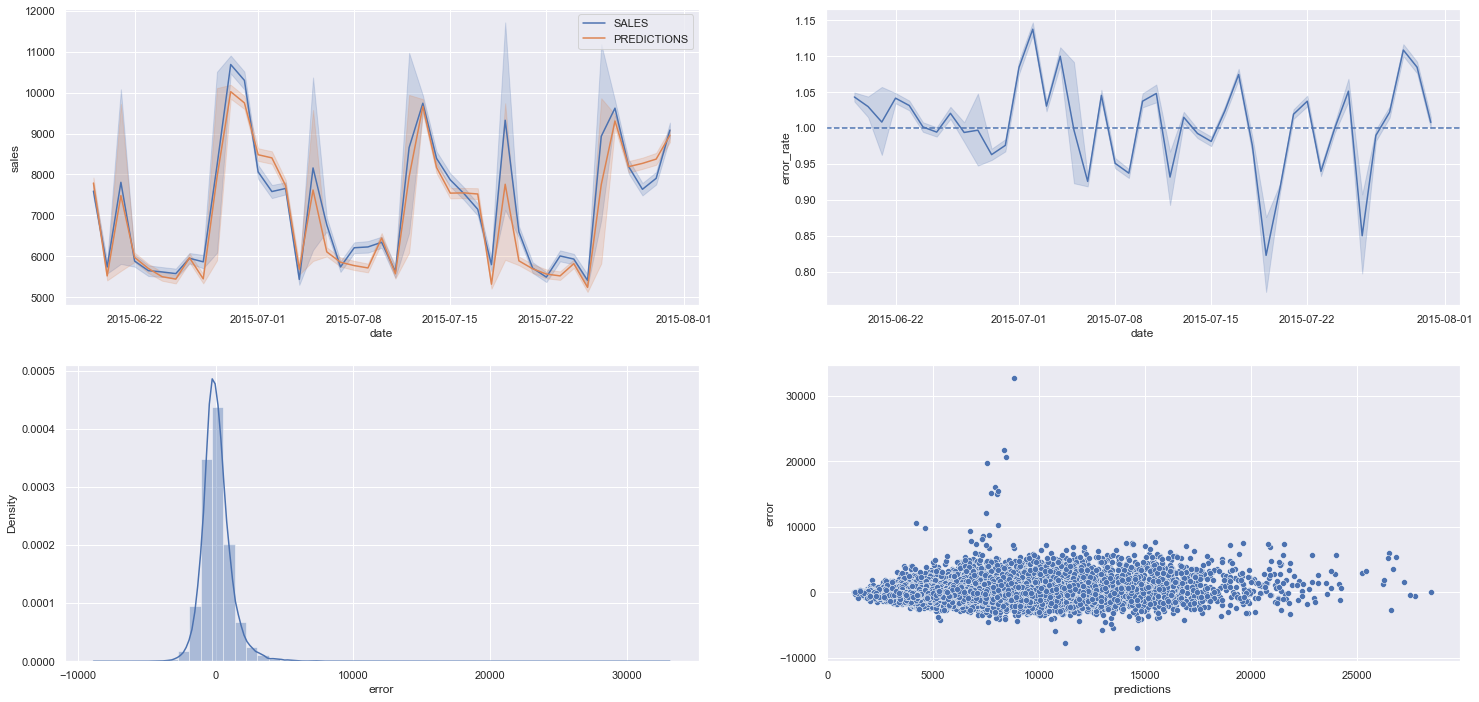

In [77]:
plt.subplot(2, 2, 1)
sns.lineplot(x='date', y='sales', data=df9, label='SALES');
sns.lineplot(x='date', y='predictions', data=df9, label='PREDICTIONS');

plt.subplot(2, 2, 2)
sns.lineplot(x='date', y='error_rate', data=df9);
plt.axhline(1, linestyle='--');

plt.subplot(2, 2, 3)
sns.distplot(df9['error']);

plt.subplot(2, 2, 4)
sns.scatterplot(df9['predictions'], df9['error']);

# 10.0. DEPLOY MODEL TO PRODUCTION


In [78]:
# Saving the rained model
pickle.dump(model_xgb_tuned, open('model/model_rossmann.pkl', 'wb'))

## 10.1. Rossmann Class

In [80]:
import math
import pickle
import datetime
import inflection
import numpy as np
import pandas as pd


class Rossmann(object):

    def __init__(self):

        self.home_path = 'C:/Users/jeova/comunidade_ds/DataScience_Em_Producao'

        self.competition_distance_scaler = pickle.load(
            open(
                self.home_path +
                'parameter/competition_distance_scaler.pkl', 'rb')
        )

        self.competition_time_month_scaler = pickle.load(
            open(
                self.home_path +
                'parameter/competition_time_month_scaler.pkl', 'rb')
        )

        self.promo_time_week_scaler = pickle.load(
            open(
                self.home_path +
                'parameter/promo_time_week_scaler.pkl', 'rb')
        )

        self.year_scaler = pickle.load(
            open(
                self.home_path +
                'parameter/year_scaler.pkl', 'rb')
        )

        self.store_type_scaler = pickle.load(
            open(
                self.home_path +
                'parameter/store_type_scaler.pkl', 'rb')
        )

    def data_cleaning(self, df1):

        # 1.1. Rename Columns
        # Removed 'Sales' and 'Costumers' columns
        cols_old = [
            'Store', 'DayOfWeek', 'Date', 'Open', 'Promo', 'StateHoliday',
            'SchoolHoliday', 'StoreType', 'Assortment', 'CompetitionDistance',
            'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
            'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval'
        ]

        def snakecase(x): return inflection.underscore(x)

        cols_new = list(map(snakecase, cols_old))

        # rename
        df1.columns = cols_new

        # 1.3. Data Types
        df1['date'] = pd.to_datetime(df1['date'])

        # 1.5. Fillout NA
        # competition_distance
        df1['competition_distance'] = df1['competition_distance'].apply(
            lambda x: 200000.0
            if math.isnan(x)
            else x
        )

        # competition_open_since_month
        df1['competition_open_since_month'] = df1.apply(
            lambda x: x['date'].month
            if math.isnan(
                x['competition_open_since_month'])
            else x['competition_open_since_month'],
            axis=1
        )

        # competition_open_since_year
        df1['competition_open_since_year'] = df1.apply(
            lambda x: x['date'].year
            if math.isnan(
                x['competition_open_since_year'])
            else
            x['competition_open_since_year'],
            axis=1
        )

        # promo2_since_week
        df1['promo2_since_week'] = df1.apply(
            lambda x: x['date'].week
            if math.isnan(
                x['promo2_since_week'])
            else x['promo2_since_week'],
            axis=1
        )

        # promo2_since_year
        df1['promo2_since_year'] = df1.apply(
            lambda x: x['date'].year
            if math.isnan(
                x['promo2_since_year'])
            else x['promo2_since_year'],
            axis=1)

        # promo_interval
        month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr',
                     5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug',
                     9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

        df1['promo_interval'].fillna(0, inplace=True)

        df1['month_map'] = df1['date'].dt.month.map(month_map)

        df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(
            lambda x: 0
            if x['promo_interval'] == 0
            else 1
            if x['month_map'] in x['promo_interval'].split(',')
            else 0,
            axis=1
        )

        # 1.6. Change Data Types
        # competiton
        df1['competition_open_since_month'] = df1[
            'competition_open_since_month'].astype(np.int64)
        df1['competition_open_since_year'] = df1[
            'competition_open_since_year'].astype(np.int64)

        # promo2
        df1['promo2_since_week'] = df1['promo2_since_week'].astype(np.int64)
        df1['promo2_since_year'] = df1['promo2_since_year'].astype(np.int64)

        return df1

    def feature_engineering(self, df2):

        # year
        df2['year'] = df2['date'].dt.year

        # month
        df2['month'] = df2['date'].dt.month

        # day
        df2['day'] = df2['date'].dt.day

        # week of year
        df2['week_of_year'] = df2['date'].dt.weekofyear

        # year week
        df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

        # competition since
        df2['competition_since'] = df2.apply(lambda x: datetime.datetime(
            year=x['competition_open_since_year'],
            month=x['competition_open_since_month'],
            day=1),
            axis=1
        )

        df2['competition_time_month'] = (
            (df2['date'] - df2['competition_since']) / 30).apply(
                lambda x: x.days).astype(int)

        # promo since
        df2['promo_since'] = df2['promo2_since_year'].astype(
            str) + '-' + df2['promo2_since_week'].astype(str)

        df2['promo_since'] = df2['promo_since'].apply(
            lambda x: datetime.datetime.strptime(
                x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7)
        )

        df2['promo_time_week'] = (
            (df2['date'] - df2['promo_since']) / 7).apply(
                lambda x: x.days).astype(int)

        # assortment
        df2['assortment'] = df2['assortment'].apply(
            lambda x: 'basic'
            if x == 'a'
            else 'extra'
            if x == 'b'
            else 'extended'
        )

        # state holiday
        df2['state_holiday'] = df2['state_holiday'].apply(
            lambda x: 'public_holiday'
            if x == 'a'
            else 'easter_holiday'
            if x == 'b'
            else 'christmas'
            if x == 'c'
            else 'regular_day'
        )

        # 3.0. PASSO 03 - FILTRAGEM DE VARIÁVEIS
        # 3.1. Filtragem das Linhas
        df2 = df2[df2['open'] != 0]  # Removed 'sales' condition

        # 3.2. Selecao das Colunas
        cols_drop = ['open', 'promo_interval', 'month_map']  # Removed 'costumers' column
        df2 = df2.drop(cols_drop, axis=1)

        return df2

    def data_preparation(self, df5):

        # 5.2. Rescaling
        # competition distance
        df5['competition_distance'] = \
            self.competition_distance_scaler.fit_transform(
            df5[['competition_distance']].values
        )

        # competition time month
        df5['competition_time_month'] = \
            self.competition_time_month_scaler.fit_transform(
            df5[['competition_time_month']].values
        )

        # promo time week
        df5['promo_time_week'] = \
            self.promo_time_week_scaler.fit_transform(
            df5[['promo_time_week']].values
        )

        # year
        df5['year'] = self.year_scaler.fit_transform(df5[['year']].values)

        # 5.3.1. Encoding
        # state_holiday - One Hot Encoding
        df5 = pd.get_dummies(
            df5, prefix=['state_holiday'], columns=['state_holiday'])

        # store_type - Label Encoding
        df5['store_type'] = self.store_type_scaler.fit_transform(
            df5['store_type'])

        # assortment - Ordinal Encoding
        assortment_dict = {'basic': 1,  'extra': 2, 'extended': 3}
        df5['assortment'] = df5['assortment'].map(assortment_dict)

        # 5.3.3. Nature Transformation
        # day_of_week
        df5['day_of_week_sin'] = df5['day_of_week'].apply(
            lambda x: np.sin(x * (2. * np.pi/7)))
        df5['day_of_week_cos'] = df5['day_of_week'].apply(
            lambda x: np.cos(x * (2. * np.pi/7)))

        # month
        df5['month_sin'] = df5['month'].apply(
            lambda x: np.sin(x * (2. * np.pi/12))
        )

        df5['month_cos'] = df5['month'].apply(
            lambda x: np.cos(x * (2. * np.pi/12))
        )

        # day
        df5['day_sin'] = df5['day'].apply(
            lambda x: np.sin(x * (2. * np.pi/30))
        )

        df5['day_cos'] = df5['day'].apply(
            lambda x: np.cos(x * (2. * np.pi/30))
        )

        # week_of_year
        df5['week_of_year_sin'] = df5['week_of_year'].apply(
            lambda x: np.sin(x * (2. * np.pi/52))
        )

        df5['week_of_year_cos'] = df5['week_of_year'].apply(
            lambda x: np.cos(x * (2. * np.pi/52))
        )

        cols_selected = [
            'store', 'promo', 'store_type', 'assortment',
            'competition_distance', 'competition_open_since_month',
            'competition_open_since_year', 'promo2', 'promo2_since_week',
            'promo2_since_year', 'competition_time_month', 'promo_time_week',
            'day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos',
            'day_sin', 'day_cos', 'week_of_year_sin', 'week_of_year_cos'
        ]

        return df5[cols_selected]

    def get_prediction(self, model, original_data, test_data):

        # Prediction
        pred = model.predict(test_data)

        # Join pred into the original data
        original_data['prediction'] = np.expm1(pred)

        return original_data.to_json(orient='records', date_format='iso')


if __name__ == '__main__':
    pass


## 10.2. API Handler

In [ ]:
import pickle
import pandas as pd
from rossmann.Rossmann import Rossmann
from flask import Flask, request, Response

# Loading model
pickle.load(
    open('C:/Users/jeova/comunidade_ds/'
         'DataScience_Em_Producao/model/model_rossmann.pkl'), 'rb')

# Initialize API
app = Flask(__name__)

@app.rout('/rossmann/predict', methods=['POST'])
def rosmann_predict():
    test_json = request.get_json()
    
    if test_json():  # Check if there is data
        # Unique example
        if isinstance(test_json, dict):
            test_raw = pd.DataFrame(test_json, index=[0])

        # Multiple example
        else:
            test_raw = pd.DataFrame(
                test_json, columns=test_json[0].keys(), index=[0])

        # Instantiate Rossmann class
        pipeline = Rossmann()
        
        # Data cleaning
        df1 = pipeline.data_cleaning(test_raw)

        # Feature engeneering
        df2 = pipeline.feature_engineering(df1)
        
        # Data preparation
        df3 = pipeline.data_preparation(df2)

        # Prediction
        df_response = pipeline.get_prediction(model, test_raw, df3)
        
        return df_response

    else:
        return Response('{}', status=200, mimetype='application/json')

if __name__ == '__main__':
    app.run('0.0.0.0')


## 10.3. API Tester

In [91]:
import requests

In [119]:
# Loading test dataset
df10 = pd.read_csv('data/test.csv')

# Merge test + store datasets
df_test = pd.merge(df10, df_store_raw, how='left', on='Store')

# Choose store for prediction
df_test = df_test[df_test['Store'].isin([24, 12, 22])]

# Removed closed days
df_test = df_test[df_test['Open'] != 0]
df_test = df_test[~df_test['Open'].isnull()]
df_test = df_test.drop('Id', axis=1)

# Convert DataFrame to json
data = json.dumps(df_test.to_dict(orient='records'))

In [120]:
# API call
url = 'http://192.168.15.6:5000/rossmann/predict'
header  = {'Content-type': 'application/json'}
data = data

r = requests.post(url, data, headers=header)
print('Status Code:', r.status_code)

Status Code: 200


In [123]:
d1 = pd.DataFrame(r.json(), columns=r.json()[0].keys())

d2 = d1[['store', 'prediction']].groupby('store').sum().reset_index()

for i in range(len(d2)):
    print('Store Number {} will sell R$ {:,.2f} in the next 6 weeks.'.format( 
          d2.loc[i, 'store'], 
          d2.loc[i, 'prediction']))

Store Number 12 will sell R$ 240,417.71 in the next 6 weeks.
Store Number 22 will sell R$ 161,388.43 in the next 6 weeks.
Store Number 24 will sell R$ 321,107.73 in the next 6 weeks.
